In [ ]:
  # @title Install dependencies
!pip install seaborn --quiet
!pip install nilearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 38.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nilearn import plotting, datasets

# @title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'runs': [5,6],   'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'runs': [7,8],   'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'runs': [9,10],  'cond':['fear','neut']},
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss','win']},
    'LANGUAGE'   : {'runs': [13,14], 'cond':['math','story']},
    'RELATIONAL' : {'runs': [15,16], 'cond':['match','relation']},
    'SOCIAL'     : {'runs': [17,18], 'cond':['mental','rnd']}
}

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# @title Download the data

import os, requests, tarfile

fname = "hcp_task.tgz"
url = "https://osf.io/s4h8j/download/"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      print(f"Downloading {fname}...")
      with open(fname, "wb") as fid:
        fid.write(r.content)
      print(f"Download {fname} completed!")

# @title Extract the data in `HCP_DIR`
fname_ex = "hcp_task"
path_name = os.path.join(HCP_DIR, fname_ex)
if not os.path.exists(path_name):
  print(f"Extracting {fname_ex}.tgz...")
  with tarfile.open(f"{fname_ex}.tgz") as fzip:
    fzip.extractall(HCP_DIR)
else:
  print(f"File {fname_ex}.tgz has already been extracted.")


regions = np.load(os.path.join(HCP_DIR, "hcp_task", "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2))

def load_single_timeseries(subject, experiment, run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str): Name of experiment
    run (int): 0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run = EXPERIMENTS[experiment]['runs'][run]
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run, dir):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment
    run (int) : 0-based run index, across all tasks

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_' + experiment + '_' + ['RL', 'LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           str(task_key), f"{cond}.txt")

    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames = [f for f in frames if np.max(f) < 176]  #removing the bug of dataset
    frames_list.append(frames)

  return frames_list

Download hcp_task.tgz completed!
Extracting hcp_task.tgz...


**Train SVM on data from all subjects**

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Define the experiment structure
EXPERIMENTS = {
    'EMOTION': {'runs': [9, 10], 'cond': ['fear', 'neut']}
}
TR = 0.72  # Time resolution, in seconds
N_SUBJECTS = 339
N_RUNS = 2

# Load timeseries data for a single subject and single run
def load_single_timeseries(subject, experiment, run, dir, remove_mean=True):
    bold_run = EXPERIMENTS[experiment]['runs'][run]
    bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
    ts = np.load(os.path.join(bold_path, bold_file))
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)
    return ts

# Load EVs (explanatory variables) data for one task experiment
def load_evs(subject, experiment, run, dir):
    frames_list = []
    task_key = 'tfMRI_' + experiment + '_' + ['RL', 'LR'][run]
    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file = os.path.join(dir, "subjects", str(subject), "EVs", str(task_key), f"{cond}.txt")
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
        start = np.floor(ev["onset"] / TR).astype(int)
        duration = np.ceil(ev["duration"] / TR).astype(int)
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        #removing the bug of dataset
        frames = [f for f in frames if np.max(f) < 176]  #removing the bug of dataset
        frames_list.append(frames)
    return frames_list

# Function to average frames for a given condition
def average_frames(data, evs, experiment, cond):
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

# Example experiment
experiment = 'EMOTION'
HCP_DIR = "./hcp"

# Collect all features and labels across subjects and runs
X_all = []
y_all = []

for subject in range(N_SUBJECTS):
    # Load data for both runs
    data_run1 = load_single_timeseries(subject=subject, experiment=experiment, run=0, dir=os.path.join(HCP_DIR, "hcp_task"))
    data_run2 = load_single_timeseries(subject=subject, experiment=experiment, run=1, dir=os.path.join(HCP_DIR, "hcp_task"))

    # Load EVs for both runs
    evs_run1 = load_evs(subject=subject, experiment=experiment, run=0, dir=os.path.join(HCP_DIR, "hcp_task"))
    evs_run2 = load_evs(subject=subject, experiment=experiment, run=1, dir=os.path.join(HCP_DIR, "hcp_task"))

    # Extract features for both runs
    Fear_run1 = average_frames(data_run1, evs_run1, experiment, 'fear')
    Neut_run1 = average_frames(data_run1, evs_run1, experiment, 'neut')
    Fear_run2 = average_frames(data_run2, evs_run2, experiment, 'fear')
    Neut_run2 = average_frames(data_run2, evs_run2, experiment, 'neut')

    # Ensure the shapes are consistent before concatenation
    if Fear_run1.shape == Neut_run1.shape == Fear_run2.shape == Neut_run2.shape == (360,):
        # Combine data from both runs
        Fear = np.vstack([Fear_run1, Fear_run2]).T  # Transpose to get (n_samples, n_features)
        Neut = np.vstack([Neut_run1, Neut_run2]).T  # Transpose to get (n_samples, n_features)

        # Create labels
        labels_fear = np.ones(Fear.shape[0])
        labels_neut = np.zeros(Neut.shape[0])
        X = np.vstack((Fear, Neut))
        y = np.hstack((labels_fear, labels_neut))

        # Append to all data
        X_all.append(X)
        y_all.append(y)

    else:
        print(f"Skipping subject {subject} due to mismatch in feature shapes.")

# Concatenate all subjects' data
X_all = np.concatenate(X_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

# Check the shapes of X_all and y_all
print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

# Scale the features
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Train SVM model using liblinear for optimization with increased iterations
svm_model = LinearSVC(max_iter=10000)
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)

X_all shape: (244080, 2)
y_all shape: (244080,)
SVM Accuracy: 0.5397615535889873


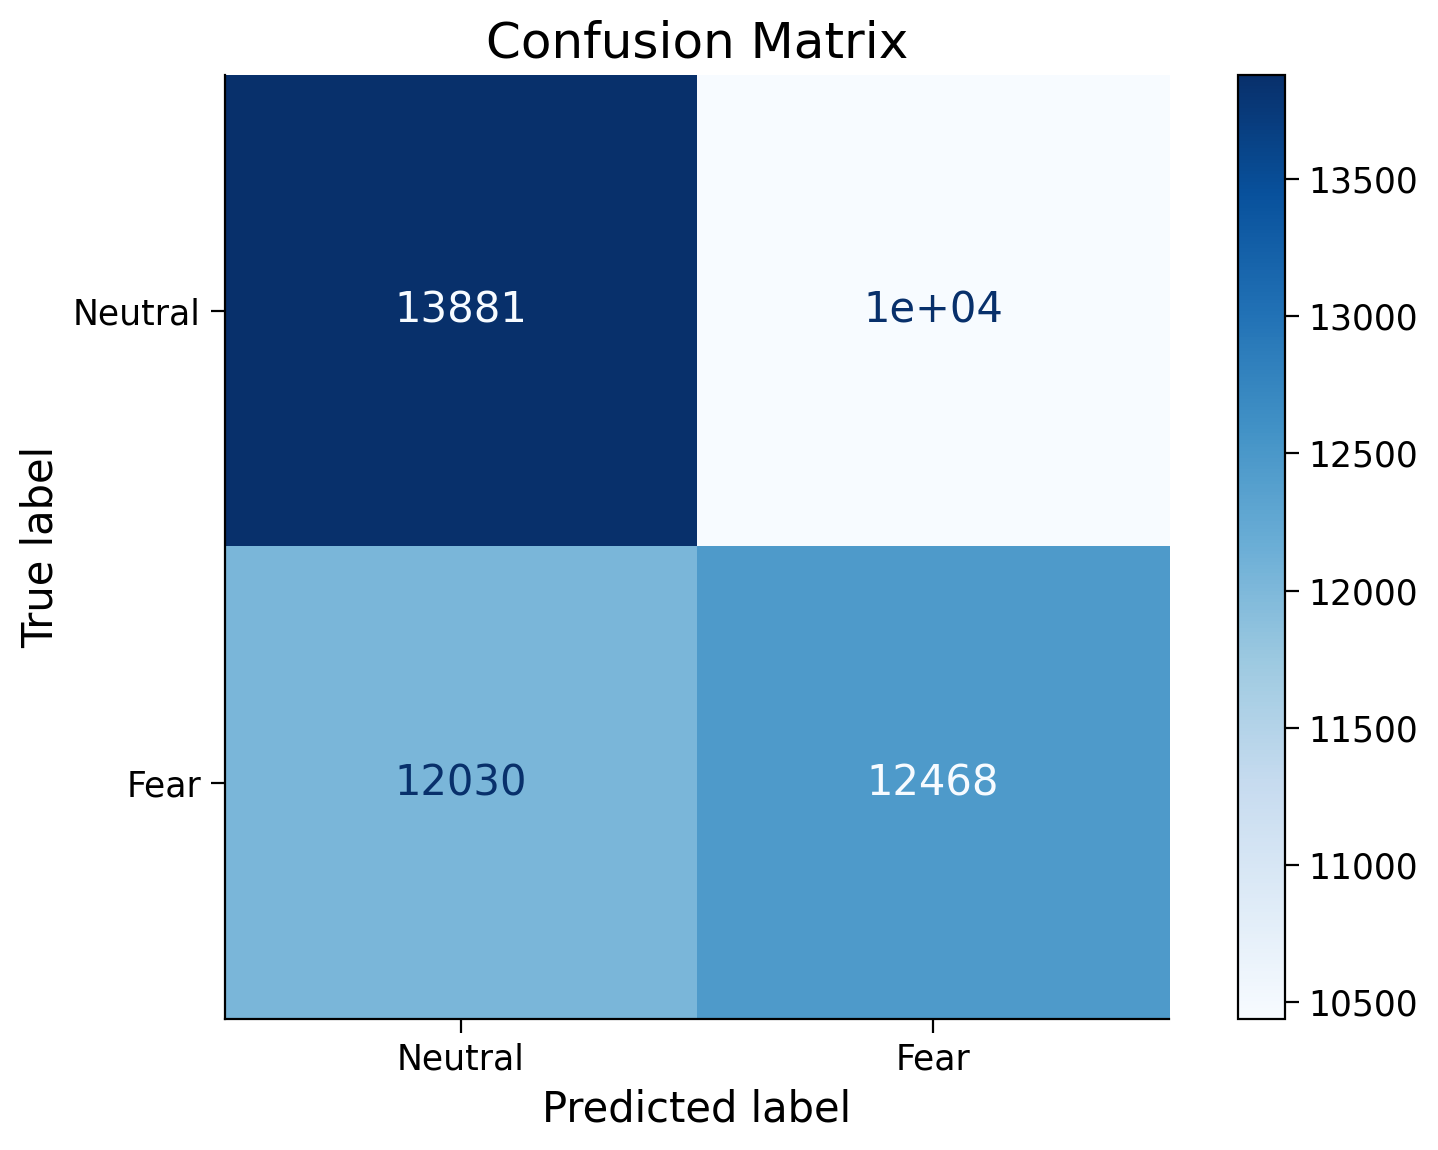

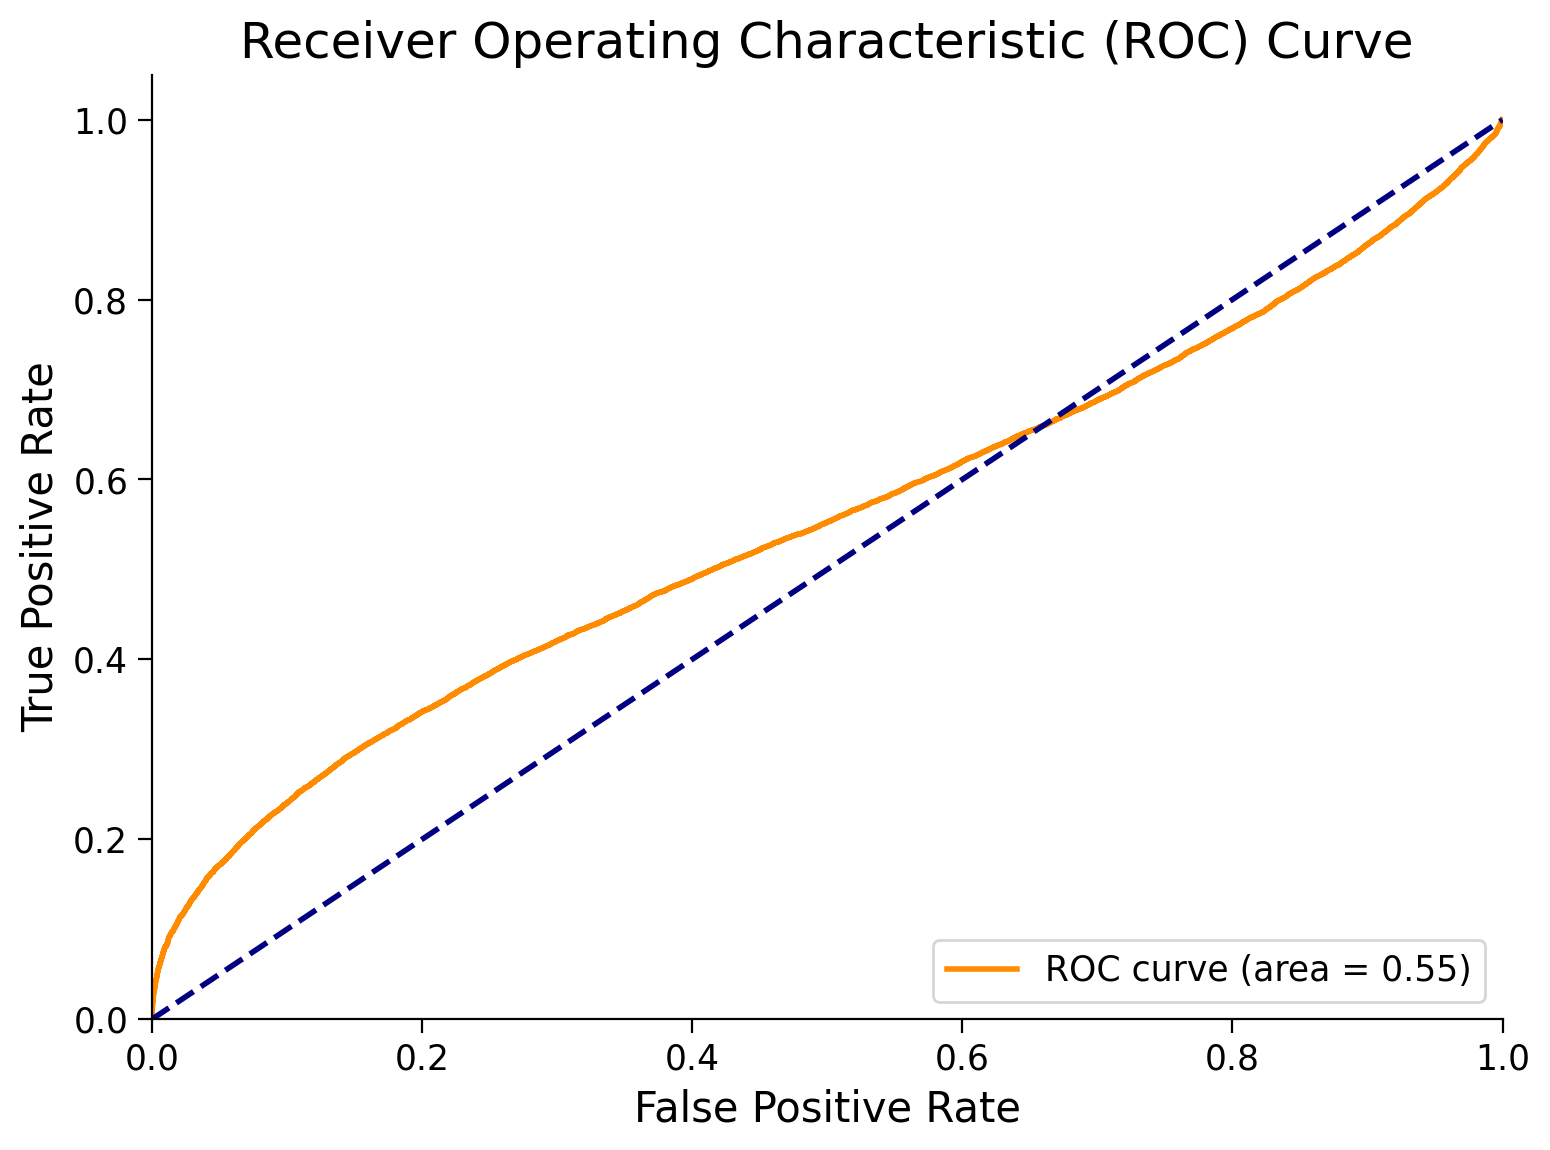

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay

# Visualizing the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Neutral', 'Fear'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Visualizing the ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Plot ROC curve
y_pred_prob = svm_model.decision_function(X_test)
plot_roc_curve(y_test, y_pred_prob)


**GCN training on EMOTION Task**

In [ ]:
# Install the necessary dependencies
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os

def read_evs(dir, subject, experiment, run, condition):
    """
    Read EV file for a given condition and return onset, duration, and amplitude.

    Args:
    - dir (str): Base directory containing the data.
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').

    Returns:
    - Tuple of (onsets, durations, responses)
    """
    task_key = f'tfMRI_{experiment}_{"LR" if run == 1 else "RL"}'
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs", task_key, f"{condition}.txt")
    ev_data = np.loadtxt(ev_file)
    onsets, durations, responses = ev_data[:, 0], ev_data[:, 1], ev_data[:, 2]
    return onsets, durations, responses

# Example usage
dir = "./hcp/hcp_task"  # Base directory
subject = 0
experiment = "EMOTION"
run = 0  # For example, run 0 for 'RL'
condition = "fear"

onsets, durations, responses = read_evs(dir, subject, experiment, run, condition)
print("Onsets:", onsets)
print("Durations:", durations)
print("Responses:", responses)

Onsets: [ 32.147  74.423 116.712]
Durations: [18. 18. 18.]
Responses: [1. 1. 1.]


In [ ]:
import numpy as np
import os

def count_timeseries(subject, experiment, run, dir):
    """
    Count the number of timepoints in the timeseries data for a specific run of an experiment.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - dir (str): Base directory containing the data.

    Returns:
    - int: Number of timepoints in the timeseries data.
    """
    # Determine the run number for the bold file
    bold_run = EXPERIMENTS[experiment]['runs'][run]

    # Construct the path to the bold file
    bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"

    # Load the timeseries data
    ts = np.load(os.path.join(bold_path, bold_file))

    # Get the number of timepoints (second dimension of the array)
    n_timepoints = ts.shape[1]

    return n_timepoints

# Example usage
subject = 0
experiment = "EMOTION"
run = 0  # For example, run 0 for 'RL'
dir = "./hcp/hcp_task"  # Base directory

n_timepoints = count_timeseries(subject, experiment, run, dir)
print(f"Number of timepoints in run {run} for experiment {experiment}: {n_timepoints}")


Number of timepoints in run 0 for experiment EMOTION: 176


In [ ]:
import numpy as np
import os

def count_timeseries(subject, experiment, run, dir):
    """
    Count the number of timepoints in the timeseries data for a specific run of an experiment.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - dir (str): Base directory containing the data.

    Returns:
    - int: Number of timepoints in the timeseries data.
    """
    # Determine the run number for the bold file
    bold_run = EXPERIMENTS[experiment]['runs'][run]

    # Construct the path to the bold file
    bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"

    # Load the timeseries data
    ts = np.load(os.path.join(bold_path, bold_file))

    # Get the number of timepoints (second dimension of the array)
    n_timepoints = ts.shape[1]

    return n_timepoints

def get_condition_timepoints(subject, experiment, run, condition, dir):
    """
    Get the number of timepoints in the timeseries data for a specific condition in a given run.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').
    - dir (str): Base directory containing the data.

    Returns:
    - int: Number of timepoints for the specified condition.
    """
    # Load the EVs data for the specified condition
    onsets, durations, _ = read_evs(dir, subject, experiment, run, condition)

    # Get the total number of timepoints
    n_timepoints = count_timeseries(subject, experiment, run, dir)

    # Create an array to mark condition times
    condition_times = np.zeros(n_timepoints)

    # Mark the times for this condition
    for onset, duration in zip(onsets, durations):
        start_frame = int(onset / TR)
        end_frame = int((onset + duration) / TR)
        condition_times[start_frame:end_frame] = 1

    # Count the number of timepoints that are part of this condition
    num_condition_timepoints = np.sum(condition_times)

    return num_condition_timepoints

# Example usage
subject = 0
experiment = "EMOTION"
dir = "./hcp/hcp_task"  # Base directory

for run in range(N_RUNS):
    print(f"\nRun {run}:")
    for condition in EXPERIMENTS[experiment]['cond']:
        num_timepoints = get_condition_timepoints(subject, experiment, run, condition, dir)
        print(f"Condition '{condition}' has {num_timepoints} timepoints.")


Run 0:
Condition 'fear' has 64.0 timepoints.
Condition 'neut' has 75.0 timepoints.

Run 1:
Condition 'fear' has 65.0 timepoints.
Condition 'neut' has 75.0 timepoints.


In [ ]:
import numpy as np
import os

def read_evs(dir, subject, experiment, run, condition):
    """
    Read EV file for a given condition and return onset, duration, and amplitude.

    Args:
    - dir (str): Base directory containing the data.
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').

    Returns:
    - Tuple of (onsets, durations, responses)
    """
    task_key = f'tfMRI_{experiment}_{"LR" if run == 1 else "RL"}'
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs", task_key, f"{condition}.txt")
    ev_data = np.loadtxt(ev_file)
    onsets, durations, responses = ev_data[:, 0], ev_data[:, 1], ev_data[:, 2]
    return onsets, durations, responses

def count_timeseries(subject, experiment, run, dir):
    """
    Count the number of timepoints in the timeseries data for a specific run of an experiment.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - dir (str): Base directory containing the data.

    Returns:
    - int: Number of timepoints in the timeseries data.
    """
    # Determine the run number for the bold file
    bold_run = EXPERIMENTS[experiment]['runs'][run]

    # Construct the path to the bold file
    bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"

    # Load the timeseries data
    ts = np.load(os.path.join(bold_path, bold_file))

    # Get the number of timepoints (second dimension of the array)
    n_timepoints = ts.shape[1]

    return n_timepoints

def get_condition_timepoints(subject, experiment, run, condition, dir, TR, block_interval=18):
    """
    Get the number of timepoints in the timeseries data for a specific condition in a given run.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').
    - dir (str): Base directory containing the data.
    - TR (float): Time resolution in seconds.
    - block_interval (int): Number of TRs between blocks.

    Returns:
    - int: Number of timepoints for the specified condition.
    """
    # Load the EVs data for the specified condition
    onsets, durations, _ = read_evs(dir, subject, experiment, run, condition)

    # Get the total number of timepoints
    n_timepoints = count_timeseries(subject, experiment, run, dir)

    # Convert onsets and durations from seconds to time points
    onsets_tr = np.floor(onsets / TR).astype(int)
    durations_tr = np.ceil(durations / TR).astype(int)

    # Create an array to mark condition times
    condition_times = np.zeros(n_timepoints)

    # Mark the times for this condition
    for onset, duration in zip(onsets_tr, durations_tr):
        start_frame = onset
        end_frame = onset + duration + block_interval  # Adding block_interval for the end frame
        end_frame = min(end_frame, n_timepoints)  # Ensure end_frame does not exceed the total timepoints
        condition_times[start_frame:end_frame] = 1

    # Count the number of timepoints that are part of this condition
    num_condition_timepoints = np.sum(condition_times)

    return num_condition_timepoints

# Example usage
subject = 300
experiment = "EMOTION"
dir = "./hcp/hcp_task"  # Base directory
TR = 0.72  # Time resolution in seconds

for run in range(N_RUNS):
    print(f"\nRun {run}:")
    for condition in EXPERIMENTS[experiment]['cond']:
        num_timepoints = get_condition_timepoints(subject, experiment, run, condition, dir, TR)
        print(f"Condition '{condition}' has {num_timepoints} timepoints.")



Run 0:
Condition 'fear' has 100.0 timepoints.
Condition 'neut' has 129.0 timepoints.

Run 1:
Condition 'fear' has 101.0 timepoints.
Condition 'neut' has 129.0 timepoints.


In [ ]:
import numpy as np
import os

def read_evs(dir, subject, experiment, run, condition):
    """
    Read EV file for a given condition and return onset, duration, and amplitude.

    Args:
    - dir (str): Base directory containing the data.
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').

    Returns:
    - Tuple of (onsets, durations, responses)
    """
    task_key = f'tfMRI_{experiment}_{"LR" if run == 1 else "RL"}'
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs", task_key, f"{condition}.txt")
    ev_data = np.loadtxt(ev_file)
    onsets, durations, responses = ev_data[:, 0], ev_data[:, 1], ev_data[:, 2]
    return onsets, durations, responses

def count_timeseries(subject, experiment, run, dir):
    """
    Count the number of timepoints in the timeseries data for a specific run of an experiment.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - dir (str): Base directory containing the data.

    Returns:
    - int: Number of timepoints in the timeseries data.
    """
    bold_run = EXPERIMENTS[experiment]['runs'][run]
    bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
    ts = np.load(os.path.join(bold_path, bold_file))
    n_timepoints = ts.shape[1]
    return n_timepoints

def get_condition_timepoints(subject, experiment, run, condition, dir, TR, block_interval=18):
    """
    Get the number of timepoints in the timeseries data for a specific condition in a given run.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').
    - dir (str): Base directory containing the data.
    - TR (float): Time resolution in seconds.
    - block_interval (int): Number of TRs between blocks.

    Returns:
    - np.ndarray: Array indicating which timepoints are covered by this condition.
    """
    onsets, durations, _ = read_evs(dir, subject, experiment, run, condition)
    n_timepoints = count_timeseries(subject, experiment, run, dir)
    onsets_tr = np.floor(onsets / TR).astype(int)
    durations_tr = np.ceil(durations / TR).astype(int)
    condition_times = np.zeros(n_timepoints)
    for onset, duration in zip(onsets_tr, durations_tr):
        start_frame = onset
        end_frame = onset + duration + block_interval
        end_frame = min(end_frame, n_timepoints)
        condition_times[start_frame:end_frame] = 1
    return condition_times

def adjust_time_series_length(ts, target_length):
    """
    Adjust the time series length to the target length by truncating or padding.

    Args:
    - ts (np.ndarray): Original time series array.
    - target_length (int): Target length for adjustment.

    Returns:
    - np.ndarray: Adjusted time series array.
    """
    current_length = ts.shape[1]
    target_length = int(target_length)  # Ensure target_length is an integer
    if current_length > target_length:
        return ts[:, :target_length]
    elif current_length < target_length:
        padding = target_length - current_length
        return np.pad(ts, ((0, 0), (0, padding)), mode='constant')
    else:
        return ts

def align_conditions(subject, experiment, run, dir, TR, block_interval=18):
    """
    Align the time series for different conditions to the same length.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - dir (str): Base directory containing the data.
    - TR (float): Time resolution in seconds.
    - block_interval (int): Number of TRs between blocks.

    Returns:
    - dict: Dictionary with adjusted time series for each condition.
    """
    conditions = EXPERIMENTS[experiment]['cond']
    condition_timepoints = {}

    for condition in conditions:
        condition_times = get_condition_timepoints(subject, experiment, run, condition, dir, TR, block_interval)
        condition_timepoints[condition] = condition_times

    # Determine the target length (length of the shortest condition)
    lengths = [np.sum(timepoints) for timepoints in condition_timepoints.values()]
    target_length = min(lengths)

    # Adjust time series lengths
    ts_adjusted = {}
    for condition, timepoints in condition_timepoints.items():
        ts_adjusted[condition] = adjust_time_series_length(timepoints.reshape(1, -1), target_length).flatten()

    return ts_adjusted

# Example usage
subject = 0
experiment = "EMOTION"
dir = "./hcp/hcp_task"  # Base directory
TR = 0.72  # Time resolution in seconds

for run in range(N_RUNS):
    print(f"\nRun {run}:")
    adjusted_ts = align_conditions(subject, experiment, run, dir, TR)
    for condition, ts in adjusted_ts.items():
        print(f"Condition '{condition}' adjusted to length {len(ts)}.")



Run 0:
Condition 'fear' adjusted to length 100.
Condition 'neut' adjusted to length 100.

Run 1:
Condition 'fear' adjusted to length 101.
Condition 'neut' adjusted to length 101.


In [ ]:
import numpy as np
import os

def read_evs(dir, subject, experiment, run, condition):
    """
    Read EV file for a given condition and return onset, duration, and amplitude.

    Args:
    - dir (str): Base directory containing the data.
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').

    Returns:
    - Tuple of (onsets, durations, responses)
    """
    task_key = f'tfMRI_{experiment}_{"LR" if run == 1 else "RL"}'
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs", task_key, f"{condition}.txt")
    ev_data = np.loadtxt(ev_file)
    onsets, durations, responses = ev_data[:, 0], ev_data[:, 1], ev_data[:, 2]
    return onsets, durations, responses

def count_timeseries(subject, experiment, run, dir):
    """
    Count the number of timepoints in the timeseries data for a specific run of an experiment.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - dir (str): Base directory containing the data.

    Returns:
    - int: Number of timepoints in the timeseries data.
    """
    bold_run = EXPERIMENTS[experiment]['runs'][run]
    bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
    ts = np.load(os.path.join(bold_path, bold_file))
    n_timepoints = ts.shape[1]
    return n_timepoints

def get_condition_timepoints(subject, experiment, run, condition, dir, TR, block_interval=18):
    """
    Get the number of timepoints in the timeseries data for a specific condition in a given run.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').
    - dir (str): Base directory containing the data.
    - TR (float): Time resolution in seconds.
    - block_interval (int): Number of TRs between blocks.

    Returns:
    - np.ndarray: Array indicating which timepoints are covered by this condition.
    """
    onsets, durations, _ = read_evs(dir, subject, experiment, run, condition)
    n_timepoints = count_timeseries(subject, experiment, run, dir)
    onsets_tr = np.floor(onsets / TR).astype(int)
    durations_tr = np.ceil(durations / TR).astype(int)
    condition_times = np.zeros(n_timepoints)
    for onset, duration in zip(onsets_tr, durations_tr):
        start_frame = onset
        end_frame = onset + duration + block_interval
        end_frame = min(end_frame, n_timepoints)
        condition_times[start_frame:end_frame] = 1
    return condition_times

def adjust_time_series_length(ts, target_length):
    """
    Adjust the time series length to the target length by truncating or padding.

    Args:
    - ts (np.ndarray): Original time series array.
    - target_length (int): Target length for adjustment.

    Returns:
    - np.ndarray: Adjusted time series array.
    """
    current_length = ts.shape[1]
    target_length = int(target_length)  # Ensure target_length is an integer
    if current_length > target_length:
        return ts[:, :target_length]
    elif current_length < target_length:
        padding = target_length - current_length
        return np.pad(ts, ((0, 0), (0, padding)), mode='constant')
    else:
        return ts

def align_conditions(subject, experiment, run, dir, TR, block_interval=18):
    """
    Align the time series for different conditions to the same length.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - dir (str): Base directory containing the data.
    - TR (float): Time resolution in seconds.
    - block_interval (int): Number of TRs between blocks.

    Returns:
    - dict: Dictionary with adjusted time series for each condition.
    """
    conditions = EXPERIMENTS[experiment]['cond']
    condition_timepoints = {}

    for condition in conditions:
        condition_times = get_condition_timepoints(subject, experiment, run, condition, dir, TR, block_interval)
        condition_timepoints[condition] = condition_times

    # Determine the target length (length of the shortest 'fear' condition)
    shortest_fear_length = float('inf')
    for run in range(N_RUNS):
        fear_times = get_condition_timepoints(subject, experiment, run, 'fear', dir, TR, block_interval)
        shortest_fear_length = min(shortest_fear_length, np.sum(fear_times))

    # Adjust time series lengths to the shortest 'fear' length
    ts_adjusted = {}
    for condition, timepoints in condition_timepoints.items():
        ts_adjusted[condition] = adjust_time_series_length(timepoints.reshape(1, -1), shortest_fear_length).flatten()

    return ts_adjusted

# Example usage
subject = 1
experiment = "EMOTION"
dir = "./hcp/hcp_task"  # Base directory
TR = 0.72  # Time resolution in seconds

for run in range(N_RUNS):
    print(f"\nRun {run}:")
    adjusted_ts = align_conditions(subject, experiment, run, dir, TR)
    for condition, ts in adjusted_ts.items():
        print(f"Condition '{condition}' adjusted to length {len(ts)}.")



Run 0:
Condition 'fear' adjusted to length 100.
Condition 'neut' adjusted to length 100.

Run 1:
Condition 'fear' adjusted to length 100.
Condition 'neut' adjusted to length 100.


In [ ]:
def read_evs(dir, subject, experiment, run, condition):
    """
    Read EV file for a given condition and return onset, duration, and amplitude.

    Args:
    - dir (str): Base directory containing the data.
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').

    Returns:
    - Tuple of (onsets, durations, responses)
    """
    task_key = f'tfMRI_{experiment}_{"LR" if run == 1 else "RL"}'
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs", task_key, f"{condition}.txt")
    ev_data = np.loadtxt(ev_file)
    onsets, durations, responses = ev_data[:, 0], ev_data[:, 1], ev_data[:, 2]
    return onsets, durations, responses

def count_timeseries(subject, experiment, run, dir):
    """
    Count the number of timepoints in the timeseries data for a specific run of an experiment.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - dir (str): Base directory containing the data.

    Returns:
    - int: Number of timepoints in the timeseries data.
    """
    bold_run = EXPERIMENTS[experiment]['runs'][run]
    bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
    ts = np.load(os.path.join(bold_path, bold_file))
    n_timepoints = ts.shape[1]
    return n_timepoints

def get_condition_timepoints(subject, experiment, run, condition, dir, TR, block_interval=18):
    """
    Get the number of timepoints in the timeseries data for a specific condition in a given run.

    Args:
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').
    - dir (str): Base directory containing the data.
    - TR (float): Time resolution in seconds.
    - block_interval (int): Number of TRs between blocks.

    Returns:
    - np.ndarray: Array indicating which timepoints are covered by this condition.
    """
    onsets, durations, _ = read_evs(dir, subject, experiment, run, condition)
    n_timepoints = count_timeseries(subject, experiment, run, dir)
    onsets_tr = np.floor(onsets / TR).astype(int)
    durations_tr = np.ceil(durations / TR).astype(int)
    condition_times = np.zeros(n_timepoints)
    for onset, duration in zip(onsets_tr, durations_tr):
        start_frame = onset
        end_frame = onset + duration + block_interval
        end_frame = min(end_frame, n_timepoints)
        condition_times[start_frame:end_frame] = 1
    return condition_times

def adjust_time_series_length(ts, target_length):
    """
    Adjust the time series length to the target length by truncating or padding.

    Args:
    - ts (np.ndarray): Original time series array.
    - target_length (int): Target length for adjustment.

    Returns:
    - np.ndarray: Adjusted time series array.
    """
    current_length = ts.shape[1]
    target_length = int(target_length)  # Ensure target_length is an integer
    if current_length > target_length:
        return ts[:, :target_length]
    elif current_length < target_length:
        padding = target_length - current_length
        return np.pad(ts, ((0, 0), (0, padding)), mode='constant')
    else:
        return ts

def find_shortest_fear_length(subjects, experiment, dir, TR):
    """
    Find the shortest 'fear' condition length across all subjects and runs.

    Args:
    - subjects (list): List of subject IDs.
    - experiment (str): Name of the experiment.
    - dir (str): Base directory containing the data.
    - TR (float): Time resolution in seconds.

    Returns:
    - int: Shortest 'fear' condition length.
    """
    shortest_fear_length = float('inf')
    for subject in subjects:
        for run in range(N_RUNS):
            fear_times = get_condition_timepoints(subject, experiment, run, 'fear', dir, TR)
            shortest_fear_length = min(shortest_fear_length, np.sum(fear_times))
    return shortest_fear_length

def align_conditions_for_all_subjects(subjects, experiment, dir, TR, block_interval=18):
    """
    Align the time series for different conditions to the same length for all subjects.

    Args:
    - subjects (list): List of subject IDs.
    - experiment (str): Name of the experiment.
    - dir (str): Base directory containing the data.
    - TR (float): Time resolution in seconds.
    - block_interval (int): Number of TRs between blocks.

    Returns:
    - dict: Dictionary with adjusted time series for each condition for each subject.
    """
    # Find the shortest 'fear' length
    shortest_fear_length = find_shortest_fear_length(subjects, experiment, dir, TR)

    all_subjects_adjusted_ts = {}

    for subject in subjects:
        subject_adjusted_ts = {}
        for run in range(N_RUNS):
            adjusted_ts = {}
            conditions = EXPERIMENTS[experiment]['cond']
            for condition in conditions:
                condition_times = get_condition_timepoints(subject, experiment, run, condition, dir, TR, block_interval)
                adjusted_ts[condition] = adjust_time_series_length(condition_times.reshape(1, -1), shortest_fear_length).flatten()
            subject_adjusted_ts[run] = adjusted_ts
        all_subjects_adjusted_ts[subject] = subject_adjusted_ts

    return all_subjects_adjusted_ts

# Example usage
subjects = range(N_SUBJECTS)  # List of subject IDs
experiment = "EMOTION"
dir = "./hcp/hcp_task"  # Base directory
TR = 0.72  # Time resolution in seconds

all_subjects_adjusted_ts = align_conditions_for_all_subjects(subjects, experiment, dir, TR)

# Print results for demonstration
for subject, runs_data in all_subjects_adjusted_ts.items():
    print(f"\nSubject {subject}:")
    for run, conditions_data in runs_data.items():
        print(f"  Run {run}:")
        for condition, ts in conditions_data.items():
            print(f"    Condition '{condition}' adjusted to length {len(ts)}.")


Subject 0:
  Run 0:
    Condition 'fear' adjusted to length 100.
    Condition 'neut' adjusted to length 100.
  Run 1:
    Condition 'fear' adjusted to length 100.
    Condition 'neut' adjusted to length 100.

Subject 1:
  Run 0:
    Condition 'fear' adjusted to length 100.
    Condition 'neut' adjusted to length 100.
  Run 1:
    Condition 'fear' adjusted to length 100.
    Condition 'neut' adjusted to length 100.

Subject 2:
  Run 0:
    Condition 'fear' adjusted to length 100.
    Condition 'neut' adjusted to length 100.
  Run 1:
    Condition 'fear' adjusted to length 100.
    Condition 'neut' adjusted to length 100.

Subject 3:
  Run 0:
    Condition 'fear' adjusted to length 100.
    Condition 'neut' adjusted to length 100.
  Run 1:
    Condition 'fear' adjusted to length 100.
    Condition 'neut' adjusted to length 100.

Subject 4:
  Run 0:
    Condition 'fear' adjusted to length 100.
    Condition 'neut' adjusted to length 100.
  Run 1:
    Condition 'fear' adjusted to length 

In [ ]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_all_timeseries(subjects, experiment, dir, TR, block_interval=18):
    """
    Load all timeseries data for the given subjects and experiment.

    Args:
    - subjects (list): List of subject IDs.
    - experiment (str): Name of the experiment.
    - dir (str): Base directory containing the data.
    - TR (float): Time resolution in seconds.
    - block_interval (int): Number of TRs between blocks.

    Returns:
    - X (np.ndarray): Array of timeseries data.
    - y (np.ndarray): Array of labels.
    """
    X = []
    y = []

    for subject in subjects:
        for run in range(N_RUNS):
            conditions = EXPERIMENTS[experiment]['cond']
            for condition in conditions:
                condition_times = get_condition_timepoints(subject, experiment, run, condition, dir, TR, block_interval)
                X.append(condition_times)
                y.append(condition)

    return np.array(X), np.array(y)

# Example usage
subjects = range(N_SUBJECTS)  # List of subject IDs
experiment = "EMOTION"
dir = "./hcp/hcp_task"  # Base directory
TR = 0.72  # Time resolution in seconds

X, y = load_all_timeseries(subjects, experiment, dir, TR)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7775 - loss: 0.4893 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0250 - val_accuracy: 1.0000 - val_loss: 2.1207e-04
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 5.0356e-05
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 1.8321e-05
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 1.0159e-05
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 6.0033e-06
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 2.9506e-06
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.7248e-04 - val_accuracy: 

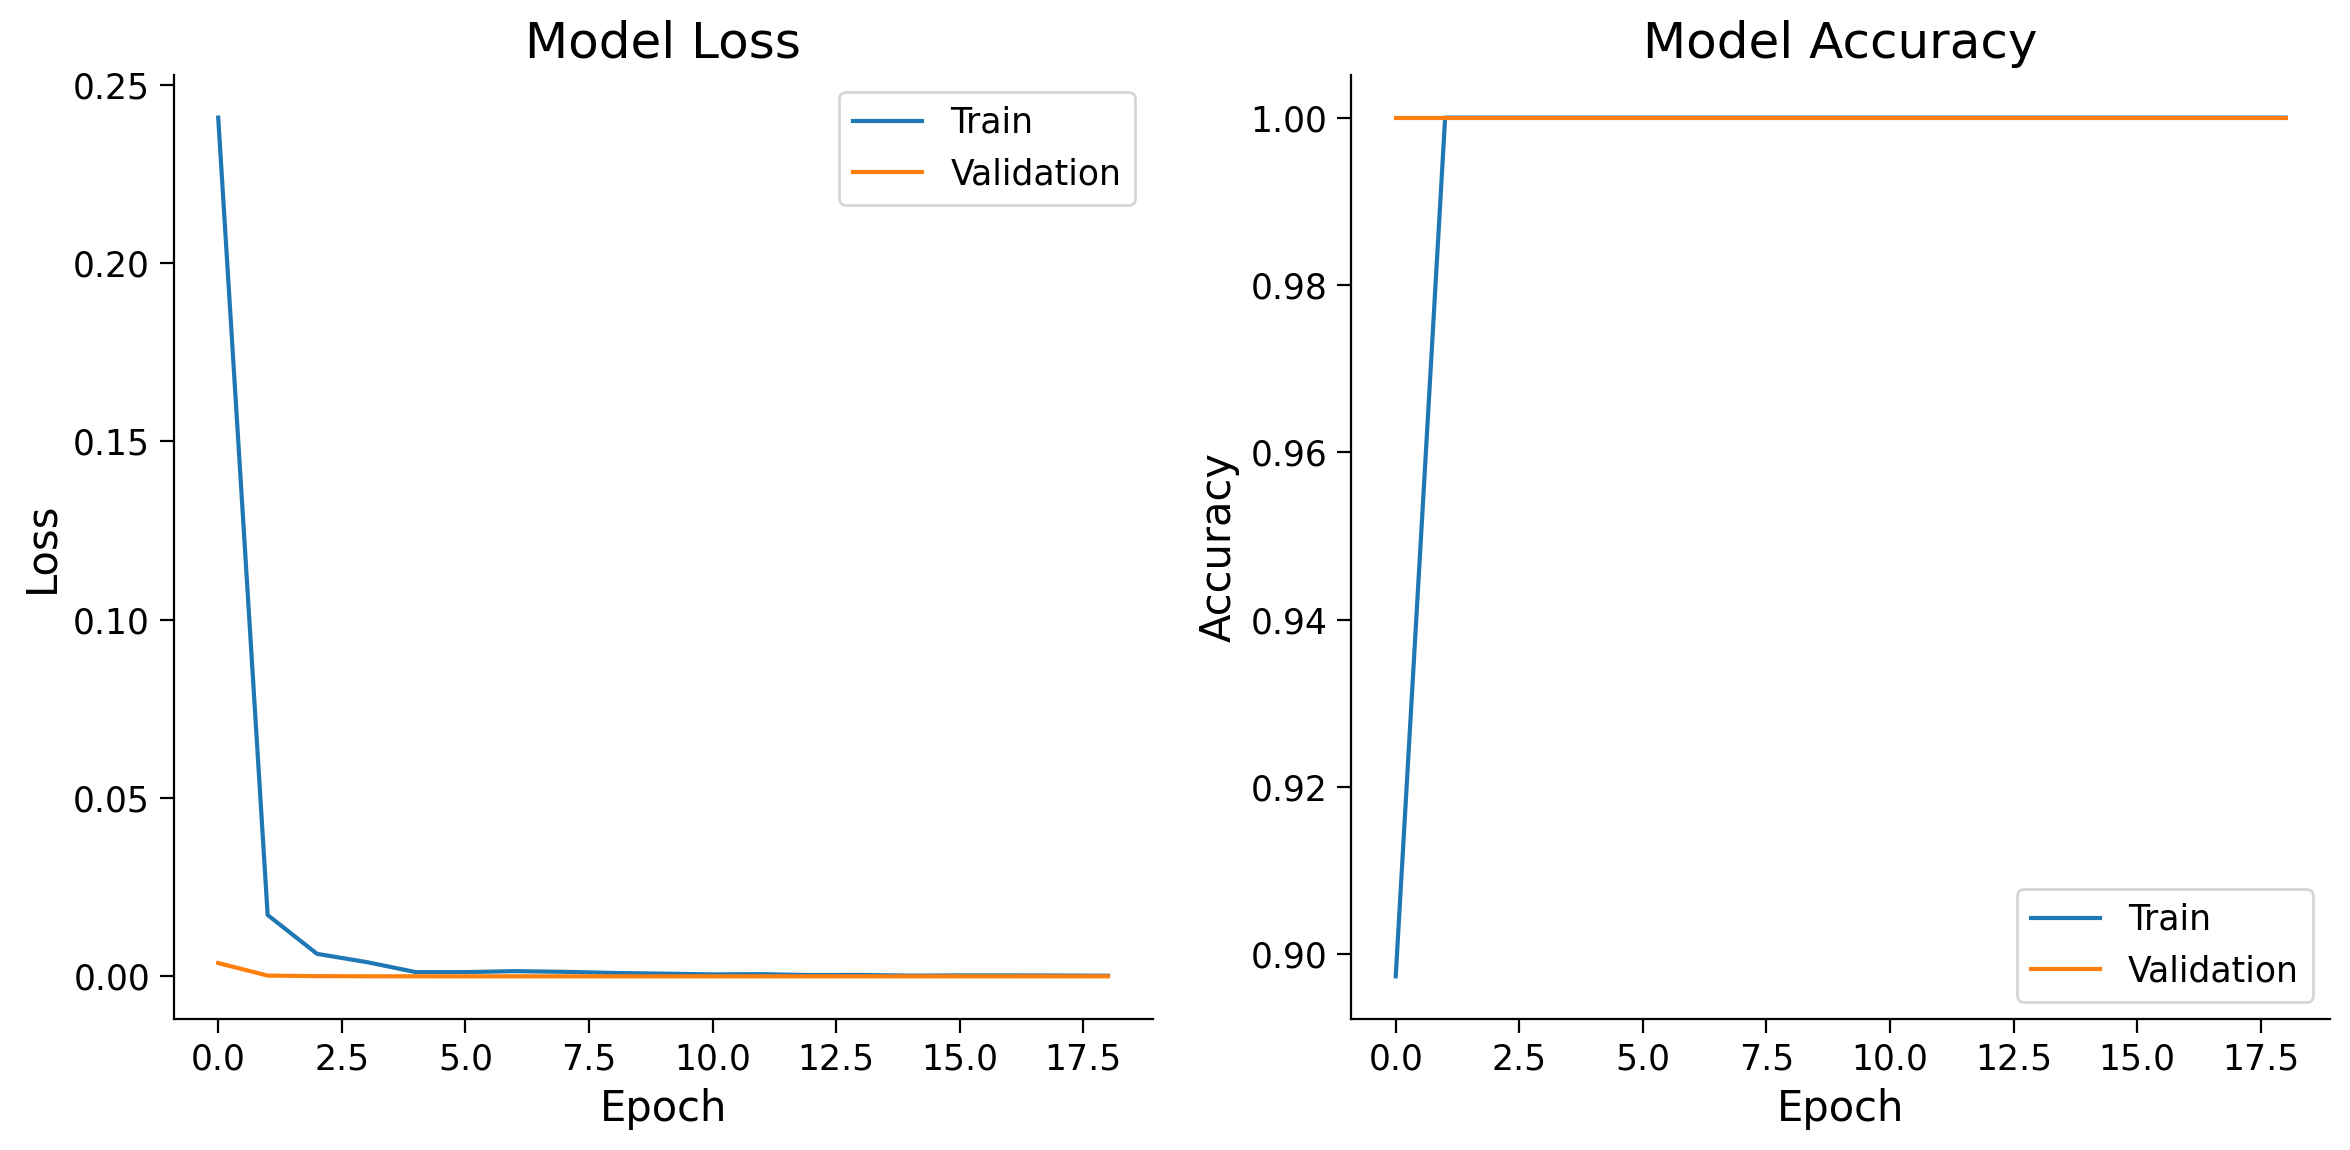

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


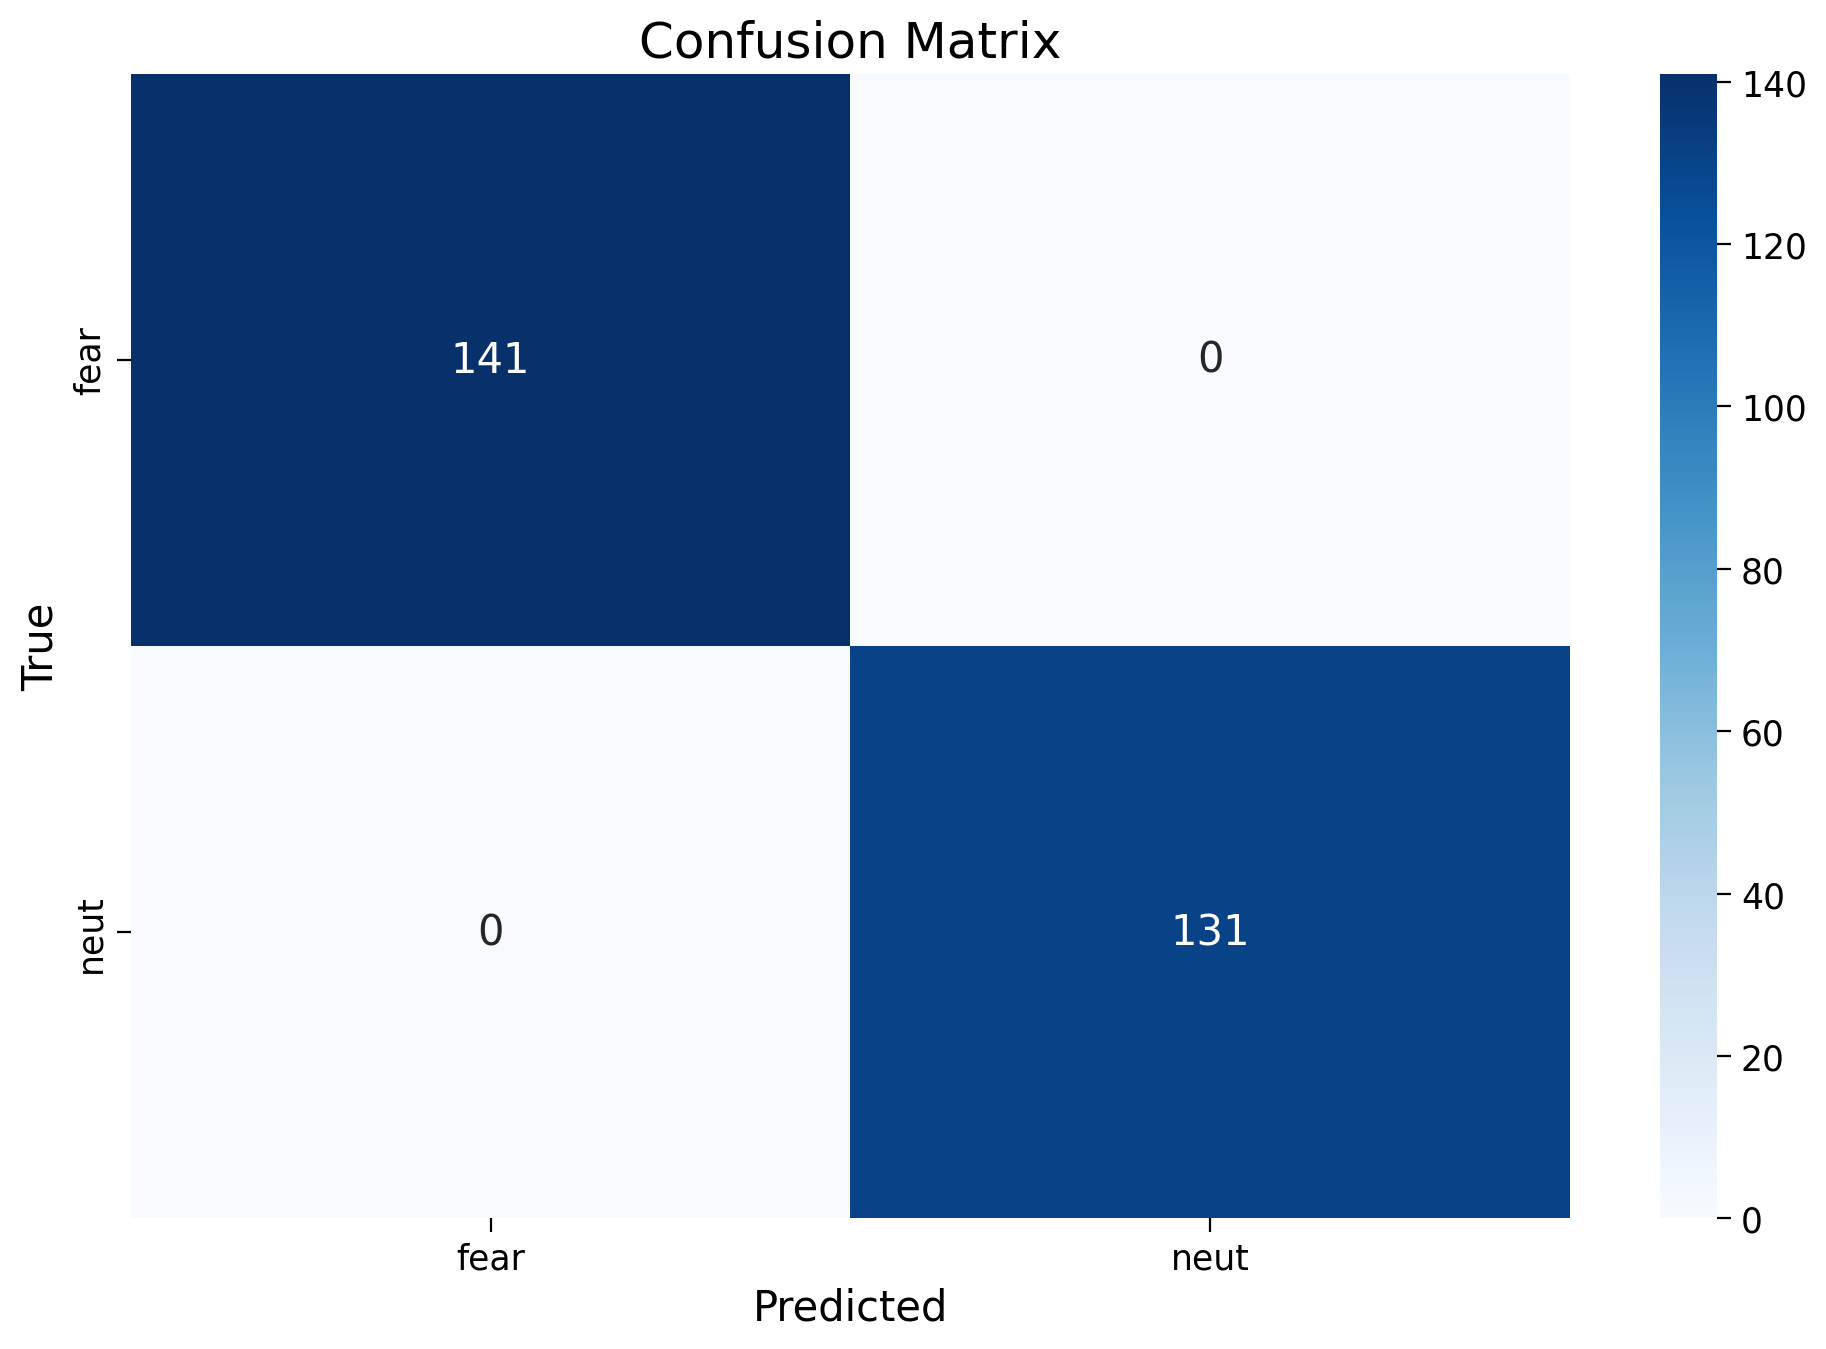

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

        fear       1.00      1.00      1.00       141
        neut       1.00      1.00      1.00       131

    accuracy                           1.00       272
   macro avg       1.00      1.00      1.00       272
weighted avg       1.00      1.00      1.00       272



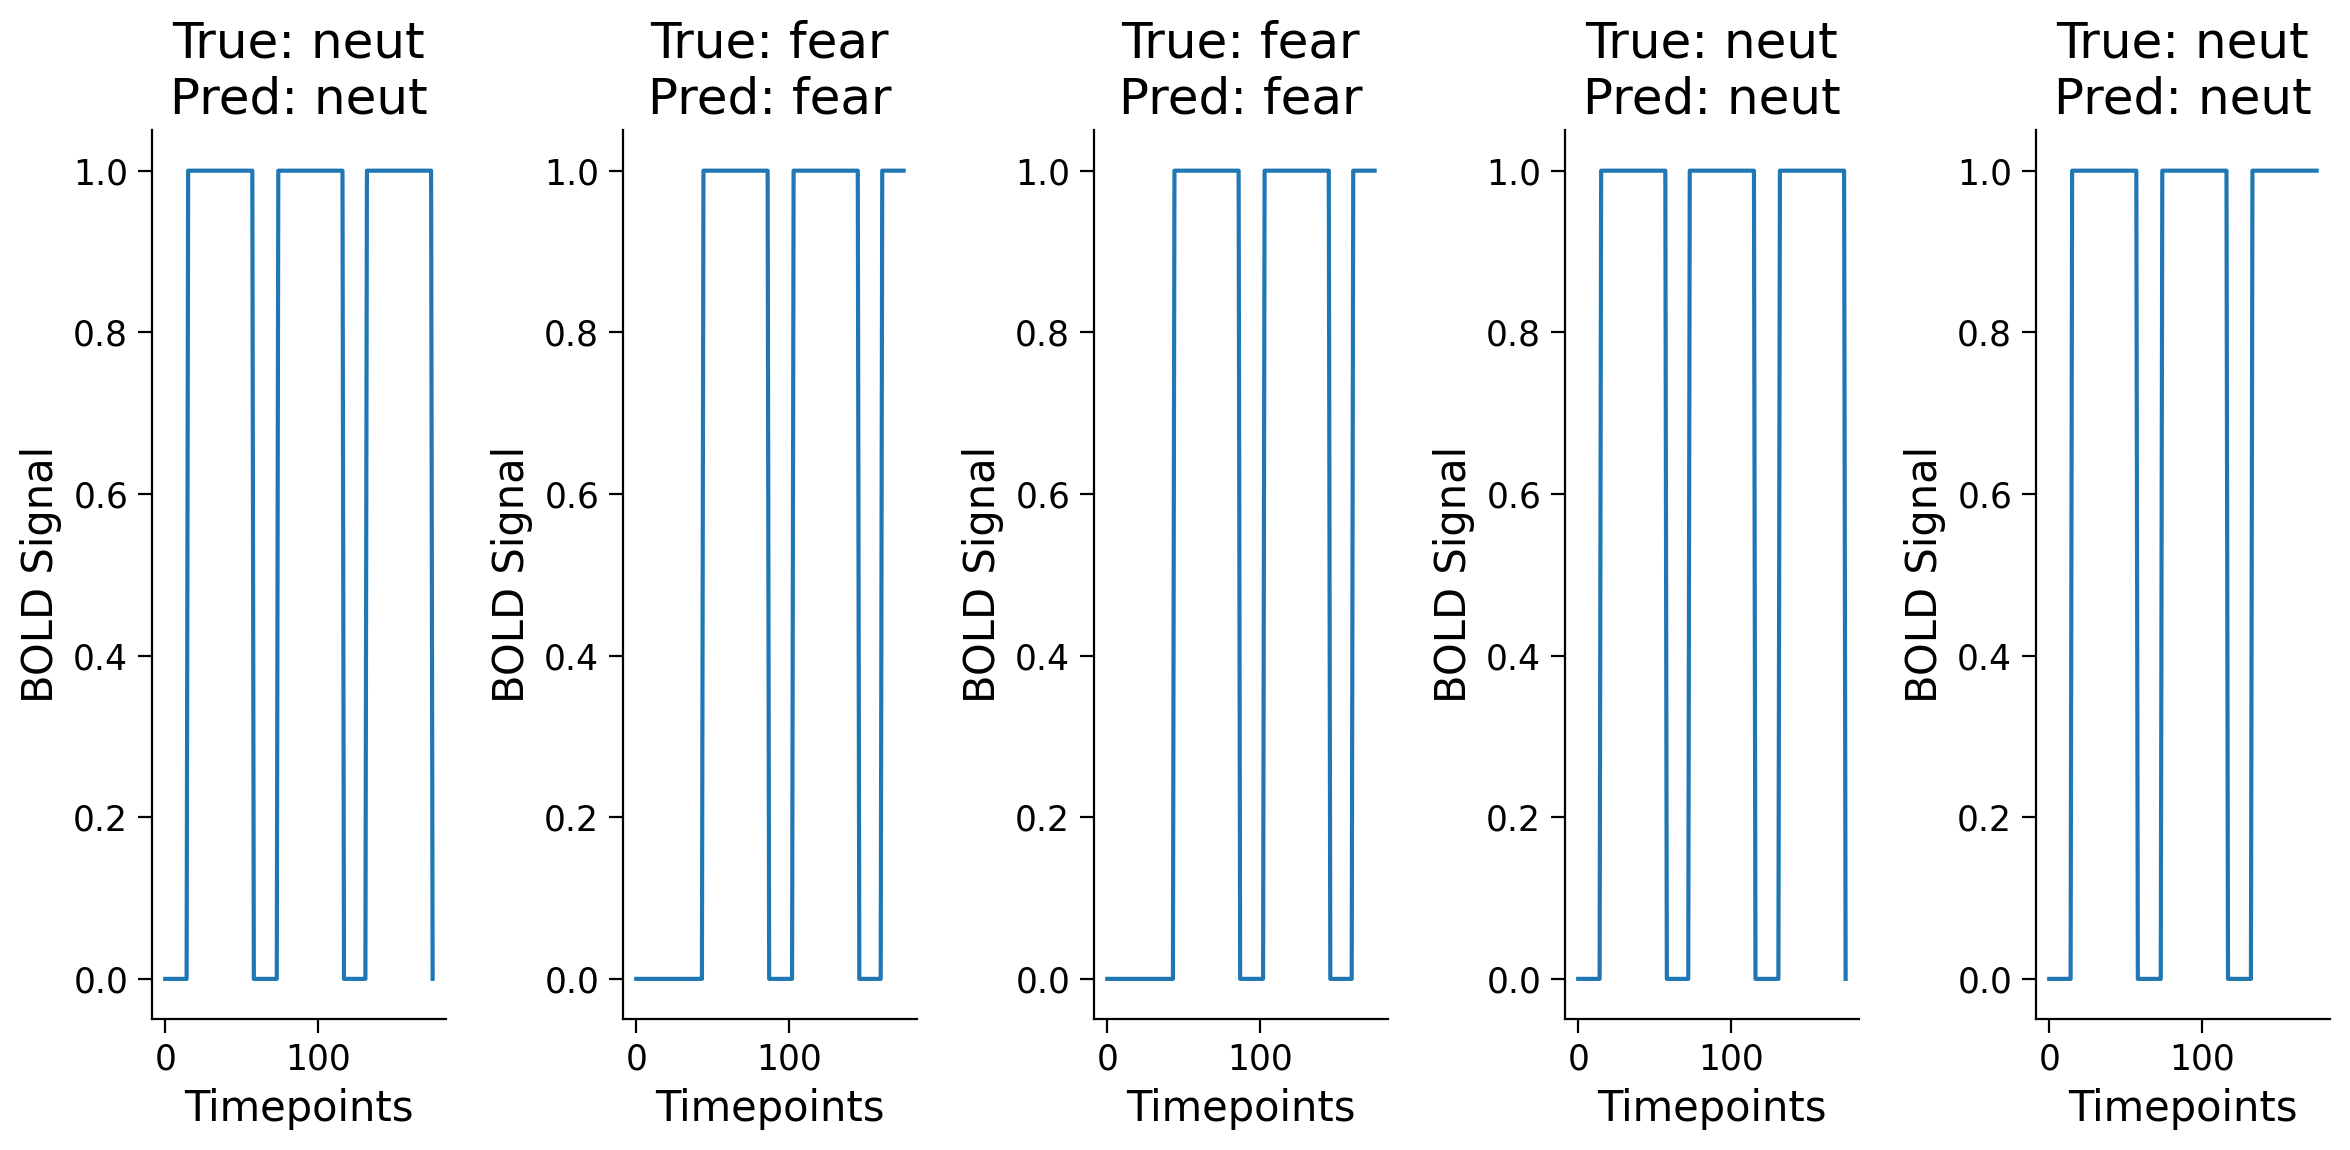

In [ ]:
def plot_predictions(X, y_true, y_pred, num_examples=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.plot(X[i])
        plt.title(f'True: {label_encoder.classes_[y_true[i]]}\nPred: {label_encoder.classes_[y_pred[i]]}')
        plt.xlabel('Timepoints')
        plt.ylabel('BOLD Signal')
    plt.show()

# Plot example predictions
plot_predictions(X_test, y_true, y_pred_classes)


In [ ]:
import os

def print_directory_structure(dir_path, indent_level=0):
    """
    Recursively print the directory structure of the given directory.

    Args:
    - dir_path (str): The path of the directory to display.
    - indent_level (int): The current indentation level for display.
    """
    try:
        # Print the current directory
        indent = '  ' * indent_level
        print(f"{indent}{os.path.basename(dir_path)}/")

        # List all files and directories in the current directory
        with os.scandir(dir_path) as entries:
            for entry in entries:
                if entry.is_dir():
                    # Recursively print subdirectories
                    print_directory_structure(entry.path, indent_level + 1)
                else:
                    # Print files
                    print(f"{indent}  {entry.name}")
    except Exception as e:
        print(f"Error accessing directory {dir_path}: {e}")

# Example usage
if __name__ == "__main__":
    # Replace this path with the directory you want to analyze
    directory_to_analyze = "./hcp"
    print_directory_structure(directory_to_analyze)


Streaming output truncated to the last 5000 lines.
            ._Sync.txt
            ._rnd.txt
            mental_resp.txt
            ._other_resp.txt
            other_resp.txt
          tfMRI_RELATIONAL_RL/
            ._error.txt
            match.txt
            ._relation.txt
            Sync.txt
            relation.txt
            error.txt
            ._Sync.txt
            ._match.txt
          ._tfMRI_LANGUAGE_LR
          ._tfMRI_EMOTION_LR
          tfMRI_GAMBLING_LR/
            neut_event.txt
            loss.txt
            ._win.txt
            ._loss.txt
            Sync.txt
            ._neut_event.txt
            ._loss_event.txt
            ._win_event.txt
            loss_event.txt
            ._Sync.txt
            win_event.txt
            win.txt
          tfMRI_LANGUAGE_RL/
            question_math.txt
            story.txt
            ._present_math.txt
            ._present_story.txt
            response_math.txt
            ._question_story.txt
          

In [ ]:
import numpy as np
import os
import torch
from torch_geometric.data import Data

# Function to read event files
def read_evs(dir, subject, experiment, run, condition):
    """
    Read EV file for a given condition and return onset, duration, and amplitude.

    Args:
    - dir (str): Base directory containing the data.
    - subject (int): Subject ID.
    - experiment (str): Name of the experiment.
    - run (int): Run index (0 or 1).
    - condition (str): Name of the condition (e.g., 'fear', 'neut').

    Returns:
    - Tuple of (onsets, durations, amplitudes)
    """
    task_key = f'tfMRI_{experiment}_{"LR" if run == 1 else "RL"}'
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs", task_key, f"{condition}.txt")
    ev_data = np.loadtxt(ev_file)
    onsets, durations, amplitudes = ev_data[:, 0], ev_data[:, 1], ev_data[:, 2]
    return onsets, durations, amplitudes

# Function to create edge index for a fully connected graph
def create_edge_index(num_nodes):
    """
    Create a simple fully connected edge index for demonstration purposes.

    Args:
    - num_nodes (int): Number of nodes (e.g., number of parcels).

    Returns:
    - edge_index (torch.Tensor): Tensor containing the edges.
    """
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
    edge_weight = torch.ones(edge_index.size(1))
    return edge_index, edge_weight

def create_event_binarized_timeseries(onsets, durations, n_timepoints, TR):
    """
    Create a binary timeseries from event onsets and durations.
    Adjust for incomplete blocks if necessary.
    """
    timeseries = np.zeros(n_timepoints)
    for onset, duration in zip(onsets, durations):
        start_frame = int(onset / TR)
        end_frame = int((onset + duration) / TR)

        # Ensure end_frame does not exceed the length of the timeseries
        if end_frame > n_timepoints:
            end_frame = n_timepoints

        timeseries[start_frame:end_frame] = 1

    return timeseries

# Function to create graph data object
def create_graph_data(timeseries, edge_index, edge_weight):
    """
    Create a torch_geometric Data object from timeseries and graph structure.

    Args:
    - timeseries (np.array): Binary timeseries data.
    - edge_index (np.array): Edge indices of the graph.
    - edge_weight (np.array): Edge weights of the graph.

    Returns:
    - data (Data): PyTorch Geometric Data object.
    """
    x = torch.tensor(timeseries, dtype=torch.float).unsqueeze(1)  # Node features
    edge_index = torch.tensor(edge_index, dtype=torch.long)  # Edge indices
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)  # Edge weights
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
    return data

# Main processing function
def process_subjects(dir, subjects, experiment, conditions, runs, n_timepoints, TR):
    """
    Process all subjects for given conditions and runs.

    Args:
    - dir (str): Base directory containing the data.
    - subjects (list): List of subject IDs.
    - experiment (str): Name of the experiment.
    - conditions (list): List of condition names (e.g., ['fear', 'neut']).
    - runs (list): List of run indices (e.g., [0, 1]).
    - n_timepoints (int): Number of timepoints in the timeseries.
    - TR (float): Time resolution in seconds.

    Returns:
    - graph_data_list (list): List of graph data objects for all subjects and conditions.
    """
    graph_data_list = []

    for subject in subjects:
        for run in runs:
            for condition in conditions:
                print(f"Processing Subject {subject}, Run {run}, Condition {condition}")

                # Read event data
                onsets, durations, amplitudes = read_evs(dir, subject, experiment, run, condition)

                # Create binary timeseries
                binary_timeseries = create_event_binarized_timeseries(onsets, durations, n_timepoints, TR)

                # Create edge index and weight
                edge_index, edge_weight = create_edge_index(N_PARCELS)

                # Create graph data object
                data = create_graph_data(binary_timeseries, edge_index.numpy(), edge_weight.numpy())

                graph_data_list.append(data)

    return graph_data_list

# Example parameters
dir = "./hcp/hcp_task"
subjects = list(range(0, 339))  # List of subjects (e.g., 0 to 338)
experiment = "EMOTION"
conditions = ["fear", "neut"]
runs = [0, 1]  # List of runs (0 for RL, 1 for LR)
n_timepoints = 185  # Number of timepoints
TR = 0.72  # Time resolution
N_PARCELS = 360  # Number of parcels (adjust as needed)

# Process all subjects and conditions
graph_data_list = process_subjects(dir, subjects, experiment, conditions, runs, n_timepoints, TR)

# Print the number of graph data objects created
print(f"Total graph data objects created: {len(graph_data_list)}")


Processing Subject 0, Run 0, Condition fear
Processing Subject 0, Run 0, Condition neut
Processing Subject 0, Run 1, Condition fear
Processing Subject 0, Run 1, Condition neut
Processing Subject 1, Run 0, Condition fear
Processing Subject 1, Run 0, Condition neut
Processing Subject 1, Run 1, Condition fear
Processing Subject 1, Run 1, Condition neut
Processing Subject 2, Run 0, Condition fear
Processing Subject 2, Run 0, Condition neut
Processing Subject 2, Run 1, Condition fear
Processing Subject 2, Run 1, Condition neut
Processing Subject 3, Run 0, Condition fear
Processing Subject 3, Run 0, Condition neut
Processing Subject 3, Run 1, Condition fear
Processing Subject 3, Run 1, Condition neut
Processing Subject 4, Run 0, Condition fear
Processing Subject 4, Run 0, Condition neut
Processing Subject 4, Run 1, Condition fear
Processing Subject 4, Run 1, Condition neut
Processing Subject 5, Run 0, Condition fear
Processing Subject 5, Run 0, Condition neut
Processing Subject 5, Run 1, Con

In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data

# Assuming the functions are already defined

# Example parameters (update these values as per your data)
subject = 1
experiment = "EMOTION"
run = 0
condition = "fear"
n_timepoints = 0
TR = 0.72
N_PARCELS = 360

# Example event data
onsets, durations, amplitudes = read_evs(dir, subject, experiment, run, condition)

# Create binary timeseries
timeseries = create_event_binarized_timeseries(onsets, durations, n_timepoints, TR)

# Create edge index and weight
edge_index, edge_weight = create_edge_index(N_PARCELS)
assert edge_index.size(1) == (N_PARCELS * (N_PARCELS - 1)) // 2  # For a fully connected graph

# Create graph data object
data = create_graph_data(timeseries, edge_index.numpy(), edge_weight.numpy())

# Verify the Data object
print(f"Node features shape: {data.x.shape}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Edge weight shape: {data.edge_attr.shape if data.edge_attr is not None else 'No edge weights'}")



Node features shape: torch.Size([0, 1])
Edge index shape: torch.Size([2, 64620])
Edge weight shape: torch.Size([64620])


In [ ]:
# Print details of the first graph data object
if graph_data_list:
    print(f"First Data object: {graph_data_list[0]}")
    print(f"Node features shape: {graph_data_list[0].x.shape}")
    print(f"Edge index shape: {graph_data_list[0].edge_index.shape}")
    print(f"Edge weight shape: {graph_data_list[0].edge_attr.shape if graph_data_list[0].edge_attr is not None else 'No edge weights'}")

First Data object: Data(x=[185, 1], edge_index=[2, 64620], edge_attr=[64620])
Node features shape: torch.Size([185, 1])
Edge index shape: torch.Size([2, 64620])
Edge weight shape: torch.Size([64620])


In [ ]:
from torch_geometric.data import DataLoader

dataloader = DataLoader(graph_data_list, batch_size=32, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
# Iterate through DataLoader for a sanity check
for batch in dataloader:
    print(batch)
    break  # Remove break to process all batches

DataBatch(x=[5920, 1], edge_index=[2, 2067840], edge_attr=[2067840], batch=[5920], ptr=[33])


In [ ]:
for batch in dataloader:
    print(type(batch))
    print(len(batch))
    print(batch)
    break

<class 'abc.DataBatch'>
32
DataBatch(x=[5920, 1], edge_index=[2, 2067840], edge_attr=[2067840], batch=[5920], ptr=[33])


In [ ]:
import numpy as np
import os
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg

# Function to read event files
def read_evs(dir, subject, experiment, run, condition):
    """
    Read EV file for a given condition and return onset, duration, and amplitude.
    """
    task_key = f'tfMRI_{experiment}_{"LR" if run == 1 else "RL"}'
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs", task_key, f"{condition}.txt")
    if not os.path.exists(ev_file):
        raise FileNotFoundError(f"{ev_file} not found.")
    ev_data = np.loadtxt(ev_file)
    onsets, durations, amplitudes = ev_data[:, 0], ev_data[:, 1], ev_data[:, 2]
    return onsets, durations, amplitudes

# Function to create edge index for a fully connected graph
def create_edge_index(num_nodes):
    """
    Create a simple fully connected edge index for demonstration purposes.
    """
    if num_nodes <= 1:
        raise ValueError("Number of nodes must be greater than 1 to create edges.")

    edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
    edge_weight = torch.ones(edge_index.size(1))

    # Print information for debugging
    print(f"Created edge index with shape: {edge_index.shape}")
    print(f"Edge index values: {edge_index}")

    return edge_index, edge_weight

# Function to create binary timeseries from events
def create_event_binarized_timeseries(onsets, durations, n_timepoints, TR):
    """
    Create a binary timeseries from event onsets and durations.
    Adjust for incomplete blocks if necessary.
    """
    timeseries = np.zeros(n_timepoints)
    for onset, duration in zip(onsets, durations):
        start_frame = int(onset / TR)
        end_frame = int((onset + duration) / TR)

        # Ensure end_frame does not exceed the length of the timeseries
        if end_frame > n_timepoints:
            end_frame = n_timepoints

        timeseries[start_frame:end_frame] = 1

    return timeseries

# Function to create graph data object
def create_graph_data(timeseries, edge_index, edge_weight):
    """
    Create a torch_geometric Data object from timeseries and graph structure.
    """
    x = torch.tensor(timeseries, dtype=torch.float).unsqueeze(1)  # Node features
    edge_index = torch.tensor(edge_index, dtype=torch.long)  # Edge indices
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)  # Edge weights

    num_nodes = x.size(0)

    # Print information for debugging
    print(f"Number of nodes: {num_nodes}")
    print(f"Edge index shape: {edge_index.shape}")
    print(f"Edge index values: {edge_index.unique()}")

    # Ensure edge_index is within valid range
    if (edge_index >= num_nodes).any():
        # More detailed error information
        invalid_indices = edge_index[edge_index >= num_nodes]
        print(f"Invalid edge indices: {invalid_indices.unique()}")
        raise ValueError("Edge index is out of bounds for the number of nodes.")

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
    return data

# Main processing function
def process_subjects(dir, subjects, experiment, conditions, runs, n_timepoints, TR, N_PARCELS):
    """
    Process all subjects for given conditions and runs.
    """
    graph_data_list = []
    for subject in subjects:
        for run in runs:
            for condition in conditions:
                print(f"Processing Subject {subject}, Run {run}, Condition {condition}")

                # Read event data
                try:
                    onsets, durations, amplitudes = read_evs(dir, subject, experiment, run, condition)
                except FileNotFoundError as e:
                    print(e)
                    continue  # Skip to next subject/condition

                # Create binary timeseries
                binary_timeseries = create_event_binarized_timeseries(onsets, durations, n_timepoints, TR)

                # Create edge index and weight
                edge_index, edge_weight = create_edge_index(N_PARCELS)

                # Create graph data object
                try:
                    data = create_graph_data(binary_timeseries, edge_index.numpy(), edge_weight.numpy())
                    data.y = torch.tensor([0])  # Placeholder for labels
                except ValueError as e:
                    print(f"Error creatin graph data: {e}")
                    continue  # Allows to skip to next subject/condition

                graph_data_list.append(data)

    return graph_data_list


# Define model
class GCN_4layers_tunning(nn.Module):
    def __init__(self, edge_index, edge_weight, n_timepoints, resolution, n_channels,
                 dropout, fc1_out, fc2_out, n_chebfilter):
        super().__init__()
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.n_timepoints = n_timepoints
        self.resolution = resolution
        self.n_channels = n_channels
        self.dropout = dropout
        self.fc1_out = fc1_out
        self.fc2_out = fc2_out
        self.n_chebfilter = n_chebfilter

        n_classes = 21

        self.conv1 = tg.nn.ChebConv(in_channels=self.n_timepoints, out_channels=n_channels, K=n_chebfilter, bias=True)
        self.conv2 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels, K=n_chebfilter, bias=True)
        self.conv3 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels, K=n_chebfilter, bias=True)
        self.conv4 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels, K=n_chebfilter, bias=True)

        self.fc1 = nn.Linear(self.resolution * n_channels, fc1_out)
        self.fc2 = nn.Linear(fc1_out, fc2_out)
        self.fc3 = nn.Linear(fc2_out, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr, batch):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = F.relu(self.conv3(x, edge_index, edge_attr))
        x = self.conv4(x, edge_index, edge_attr)

        x = tg.nn.global_mean_pool(x, batch)

        x = x.view(-1, self.resolution * self.n_channels)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

# Training and validation functions
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch in dataloader:
        X = batch.x
        edge_index = batch.edge_index
        edge_attr = batch.edge_attr
        y = batch.y
        batch_indices = batch.batch

        num_nodes = X.size(0)

        # Check that edge_index is within valid range
        if (edge_index >= num_nodes).any():
            raise ValueError("Edge index is out of bounds for the number of nodes in this batch.")

        # Print batch information for debugging
        print(f"Batch X shape: {X.shape}")
        print(f"Batch edge_index shape: {edge_index.shape}")
        print(f"Batch batch size: {len(batch_indices)}")
        print(f"Unique node indices in edge_index: {edge_index.unique()}")

        # Forward pass
        pred = model(X, edge_index, edge_attr, batch_indices)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print metrics
        print(f"Loss: {loss.item()}")


def valid_test_loop(dataloader, model, loss_fn):
    model.eval()
    valid_loss, correct = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            X = batch.x
            edge_index = batch.edge_index
            edge_attr = batch.edge_attr
            y = batch.y
            batch_indices = batch.batch

            # Forward pass
            pred = model(X, edge_index, edge_attr, batch_indices)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    valid_loss /= len(dataloader.dataset)
    accuracy = correct / len(dataloader.dataset)

    return valid_loss, accuracy

# parameters
dir = "./hcp/hcp_task"
subjects = list(range(0, 339))  # List of subjects (0 to 338)
experiment = "EMOTION"
conditions = ["fear", "neut"]
runs = [0, 1]
n_timepoints = 185
TR = 0.72
N_PARCELS = 360

# Process all subjects and conditions
graph_data_list = process_subjects(dir, subjects, experiment, conditions, runs, n_timepoints, TR, N_PARCELS)

# Load data into DataLoader
dataloader = DataLoader(graph_data_list, batch_size=32, shuffle=True)

# Initialize model, loss function, and optimizer
model = GCN_4layers_tunning(edge_index=None, edge_weight=None,
                            n_timepoints=n_timepoints, resolution=N_PARCELS,
                            n_channels=32, dropout=0.25, fc1_out=256, fc2_out=128,
                            n_chebfilter=2)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training
train_loop(dataloader, model, loss_fn, optimizer)

# Evaluation
valid_loss, valid_accuracy = valid_test_loop(dataloader, model, loss_fn)
print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")


Streaming output truncated to the last 5000 lines.
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
        182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
        196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
        210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
        224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
        238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
        252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
        266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279,
        280, 

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
# Vor der Erstellung des Edge-Index
print(f"Verarbeite Subjekt {subject}, Lauf {run}, Bedingung {condition}")
#print(f"Anzahl der Knoten: {num_nodes}")

# Nach der Erstellung des Edge-Index
print(f"Edge-Index-Form: {edge_index.shape}")
print(f"Edge-Index-Werte: {edge_index}")

# Überprüfen, ob alle Kantenindizes innerhalb des gültigen Bereichs liegen
invalid_edges = edge_index[0] >= 359
if torch.any(invalid_edges):
    print(f"Ungültige Kantenindizes: {edge_index[:, invalid_edges]}")



In [ ]:
# Clone the GitHub repository
!git clone https://github.com/courtois-neuromod/hcptrt-decoding.git

# List the contents of the repository and the gcn/test_notebooks directory to verify the files
!ls hcptrt-decoding
!ls hcptrt-decoding/gcn
!ls hcptrt-decoding/gcn/test_notebooks

# Append the correct directory to the Python path
import sys
sys.path.append('/content/hcptrt-decoding')
sys.path.append('/content/hcptrt-decoding/gcn')
sys.path.append('/content/hcptrt-decoding/gcn/test_notebooks')

# Import the modules from the respository
import data_concat_windows_gcn
import time_windows_dataset
import graph_construction
import gcn_model
import conectomes_generator

In [ ]:
import numpy as np
import os
import torch
from torch_geometric.data import Data

# Example parameters
dir = "./hcp/hcp_task"
subjects = list(range(0, 339))  # List of subjects (e.g., 0 to 338)
experiment = "EMOTION"
conditions = ["fear", "neut"]
runs = [0, 1]  # List of runs (0 for RL, 1 for LR)
n_timepoints = 156  # Number of timepoints
TR = 0.72  # Time resolution
N_PARCELS = 360  # Number of parcels (adjust as needed)

def load_evs(subject, experiment, run, dir):
    """Load EVs (explanatory variables) data for one task experiment.

    Args:
      subject (int): 0-based subject ID to load
      experiment (str) : Name of experiment
      run (int) : 0-based run index, across all tasks
      dir (str): Base directory where the data is stored

    Returns:
      evs (dict): A dictionary with condition names as keys and
                  binary timeseries arrays as values
    """
    frames_dict = {}
    task_key = 'tfMRI_' + experiment + '_' + ['RL', 'LR'][run]

    for cond in ["fear", "neut"]:  # Replace with EXPERIMENTS[experiment]['cond']
        ev_file = os.path.join(dir, "subjects", str(subject), "EVs", str(task_key), f"{cond}.txt")

        # Load EV data
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev = dict(zip(["onset", "duration", "amplitude"], ev_array))

        # Determine frame indices for each event
        start = np.floor(ev["onset"] / TR).astype(int)
        duration = np.ceil(ev["duration"] / TR).astype(int)
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames = [f for f in frames if np.max(f) < N_TIMEPOINTS]  # Remove out-of-bounds frames

        # Create binary timeseries
        timeseries = np.zeros(N_TIMEPOINTS)
        for f in frames:
            timeseries[f] = 1

        frames_dict[cond] = timeseries

    return frames_dict

def create_edge_index(num_nodes):
    """Create a simple fully connected edge index for demonstration purposes.

    Args:
      num_nodes (int): Number of nodes (e.g., number of parcels).

    Returns:
      edge_index (torch.Tensor): Tensor containing the edges.
      edge_weight (torch.Tensor): Tensor containing the edge weights.
    """
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
    edge_weight = torch.ones(edge_index.size(1))
    return edge_index, edge_weight

def create_graph_data(timeseries, edge_index, edge_weight):
    """Convert timeseries to PyTorch Geometric Data object.

    Args:
      timeseries (np.array): Binary timeseries indicating event presence.
      edge_index (np.array): Edge indices.
      edge_weight (np.array): Edge weights.

    Returns:
      data (Data): PyTorch Geometric Data object.
    """
    x = torch.tensor(timeseries, dtype=torch.float).unsqueeze(1)  # Node features
    edge_index = torch.tensor(edge_index, dtype=torch.long)  # Edge indices
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)  # Edge weights
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
    return data


# Example usage
dir = "./hcp/hcp_task"
subject = 0
experiment = "EMOTION"
run = 0  # For example, run 0 for 'RL'
edge_index, edge_weight = create_edge_index(N_PARCELS)

# Load EV data
frames_dict = load_evs(subject, experiment, run, dir)

# Convert to graph data
graph_data_dict = {}
for cond, timeseries in frames_dict.items():
    data = create_graph_data(timeseries, edge_index.numpy(), edge_weight.numpy())
    graph_data_dict[cond] = data

# Example dataset creation (including both conditions here)
dataset = [graph_data_dict["fear"], graph_data_dict["neut"]]

In [ ]:
def collate_graphs(batch):
    """Custom collate function to handle lists of torch_geometric.data.Data objects."""
    return Batch.from_data_list(batch)

# Create a DataLoader with the custom collate function
batch_size = 2  # Adjust batch size as needed
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_graphs)

# Print to check
for batch in dataloader:
    print(batch)

In [ ]:
import os
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader, Batch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg

# Define experiment parameters
EXPERIMENTS = {
    'EMOTION': {
        'cond': ['fear', 'neut']
    }
}

# Parameters
dir = "./hcp/hcp_task"
subjects = [0, 1]  # List of subjects
experiment = "EMOTION"
conditions = ["fear", "neut"]
runs = [0, 1]  # List of runs (0 for RL, 1 for LR)
N_TIMEPOINTS = 176  # Number of timepoints
TR = 0.72  # Time resolution
N_PARCELS = 360  # Number of parcels

def load_evs(subject, experiment, run, dir):
    """Load EVs (explanatory variables) data for one task experiment."""
    frames_list = []
    task_key = 'tfMRI_' + experiment + '_' + ['RL', 'LR'][run]
    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file = os.path.join(dir, "subjects", str(subject), "EVs", str(task_key), f"{cond}.txt")
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
        start = np.floor(ev["onset"] / TR).astype(int)
        duration = np.ceil(ev["duration"] / TR).astype(int)
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)
    return frames_list

def create_event_binarized_timeseries(onsets, durations, n_timepoints, TR):
    """Create a binary timeseries from event onsets and durations."""
    timeseries = np.zeros(n_timepoints)
    for onset, duration in zip(onsets, durations):
        start_frame = int(onset / TR)
        end_frame = int((onset + duration) / TR)
        timeseries[start_frame:end_frame] = 1
    return timeseries

def create_edge_index(num_nodes):
    """Create a simple fully connected edge index for demonstration purposes."""
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
    edge_weight = torch.ones(edge_index.size(1))
    return edge_index, edge_weight

def create_graph_data(timeseries, edge_index, edge_weight):
    x = torch.tensor(timeseries, dtype=torch.float).unsqueeze(1)  # Node features
    edge_index = torch.tensor(edge_index, dtype=torch.long)  # Edge indices
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)  # Edge weights
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
    return data

def load_all_data(dir, subjects, experiment, runs, n_timepoints, TR):
    graph_data_dict = {"fear": [], "neut": []}
    for subject in subjects:
        for run in runs:
            frames_list = load_evs(subject, experiment, run, dir)
            for condition, frames in zip(['fear', 'neut'], frames_list):
                onsets = np.concatenate([np.array(f) for f in frames])
                durations = np.concatenate([np.array([len(f)]) for f in frames])
                timeseries = create_event_binarized_timeseries(onsets, durations, n_timepoints, TR)
                timeseries = timeseries[:n_timepoints]  # Truncate timeseries to uniform length
                graph_data = create_graph_data(timeseries, edge_index, edge_weight)
                graph_data_dict[condition].append(graph_data)
    return graph_data_dict

# Custom collate function to handle lists of torch_geometric.data.Data objects
def collate_graphs(batch):
    return Batch.from_data_list(batch)

# Parameters
dir = "./hcp/hcp_task"
subjects = [0, 1]  # List of subjects
experiment = "EMOTION"
conditions = ["fear", "neut"]
runs = [0, 1]  # List of runs (0 for RL, 1 for LR)
N_TIMEPOINTS = 176  # Number of timepoints
TR = 0.72  # Time resolution
N_PARCELS = 360  # Number of parcels

# Create edge index and edge weight
edge_index, edge_weight = create_edge_index(N_PARCELS)

# Load data
graph_data_dict = load_all_data(dir, subjects, experiment, runs, N_TIMEPOINTS, TR)

# Create dataset and dataloader
dataset = graph_data_dict["fear"] + graph_data_dict["neut"]  # Combine both conditions

dataloader = DataLoader(dataset, batch_size=4, collate_fn=collate_graphs)

# Print to check
for batch in dataloader:
    print(batch)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model = model.double()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.double())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), batch * dataloader.batch_size

        correct = (pred.argmax(1) == y).type(torch.float).sum().item()
        correct /= X.shape[0]
#         print(f"#{batch:>5};\ttrain_loss:{loss:>0.3f};\ttrain_accuracy:{(100*correct):>5.1f}%\t\t[{current:>5d}/{size:>5d}]")

def valid_test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model.forward(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= size
    correct /= size

    return loss, correct


class GCN(torch.nn.Module):
    def __init__(self, edge_index, edge_weight, n_timepoints, resolution, n_classes=21):
        super().__init__()
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.n_timepoints = n_timepoints
        self.resolution = resolution

        # 1 input image channel, 32 output channels, 2 Chebyshev filter size
        self.conv1 = tg.nn.ChebConv(in_channels=self.n_timepoints,out_channels=32,K=2,bias=True)
        self.conv2 = tg.nn.ChebConv(in_channels=32,out_channels=32,K=2,bias=True)
        self.conv3 = tg.nn.ChebConv(in_channels=32,out_channels=32,K=2,bias=True)
        self.conv4 = tg.nn.ChebConv(in_channels=32,out_channels=32,K=2,bias=True)
        self.conv5 = tg.nn.ChebConv(in_channels=32,out_channels=32,K=2,bias=True)
        self.conv6 = tg.nn.ChebConv(in_channels=32,out_channels=32,K=2,bias=True)

        # affine operation: y = Wx + b
        self.fc1 = nn.Linear(self.resolution*32, 256) # tunning  256
        self.fc2 = nn.Linear(256, 128) # tunning  128
        self.fc3 = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.25) # tunning 0.25

    def forward(self, x):
        x = F.relu(self.conv1(x, self.edge_index, self.edge_weight))
        x = F.relu(self.conv2(x, self.edge_index, self.edge_weight))
        x = F.relu(self.conv3(x, self.edge_index, self.edge_weight))
        x = F.relu(self.conv4(x, self.edge_index, self.edge_weight))
        x = F.relu(self.conv5(x, self.edge_index, self.edge_weight))
        x = self.conv6(x, self.edge_index, self.edge_weight)

        x = tg.nn.global_mean_pool(x,torch.from_numpy(np.array(range(x.size(0)),dtype=int)))
#         x = x.view(-1,256*32) #444
        x = x.view(-1,self.resolution*32)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x



class GCN_2layers_tunning(torch.nn.Module):
    def __init__(self, edge_index, edge_weight, n_timepoints, resolution, n_channels,
                 dropout, fc1_out, fc2_out, n_chebfilter):
        super().__init__()
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.n_timepoints = n_timepoints
        self.resolution = resolution
        self.n_channels = n_channels
        self.dropout = dropout
        self.fc1_out = fc1_out
        self.fc2_out = fc2_out
        self.n_chebfilter = n_chebfilter

        n_classes=21

        # 1 input image channel, 32 output channels, 2 Chebyshev filter size
        self.conv1 = tg.nn.ChebConv(in_channels=self.n_timepoints, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        self.conv2 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        # affine operation: y = Wx + b
        self.fc1 = nn.Linear(self.resolution*n_channels, fc1_out)
        self.fc2 = nn.Linear(fc1_out, fc2_out)
        self.fc3 = nn.Linear(fc2_out, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.conv1(x, self.edge_index, self.edge_weight))
        x = self.conv2(x, self.edge_index, self.edge_weight)

        x = tg.nn.global_mean_pool(x,torch.from_numpy(np.array(range(x.size(0)),dtype=int)))

        x = x.view(-1,self.resolution*self.n_channels)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x



class GCN_6layers_tunning(torch.nn.Module):

    def __init__(self, edge_index, edge_weight, n_timepoints, resolution, n_channels,
                 dropout, fc1_out, fc2_out, n_chebfilter):
        super().__init__()
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.n_timepoints = n_timepoints
        self.resolution = resolution
        self.n_channels = n_channels
        self.dropout = dropout
        self.fc1_out = fc1_out
        self.fc2_out = fc2_out
        self.n_chebfilter = n_chebfilter

        n_classes=21

        # 1 input image channel, 32 output channels, 2 Chebyshev filter size
        self.conv1 = tg.nn.ChebConv(in_channels=self.n_timepoints, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        self.conv2 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        self.conv3 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        self.conv4 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        self.conv5 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        self.conv6 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        # affine operation: y = Wx + b
        self.fc1 = nn.Linear(self.resolution*n_channels, fc1_out) #444
        self.fc2 = nn.Linear(fc1_out, fc2_out)
        self.fc3 = nn.Linear(fc2_out, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.conv1(x, self.edge_index, self.edge_weight))
        x = F.relu(self.conv2(x, self.edge_index, self.edge_weight))
        x = F.relu(self.conv3(x, self.edge_index, self.edge_weight))
        x = F.relu(self.conv4(x, self.edge_index, self.edge_weight))
        x = F.relu(self.conv5(x, self.edge_index, self.edge_weight))
        x = self.conv6(x, self.edge_index, self.edge_weight)

        x = tg.nn.global_mean_pool(x,torch.from_numpy(np.array(range(x.size(0)),dtype=int)))

        x = x.view(-1,self.resolution*self.n_channels)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

class GCN_4layers_tunning(torch.nn.Module):

    def __init__(self, edge_index, edge_weight, n_timepoints, resolution, n_channels,
                 dropout, fc1_out, fc2_out, n_chebfilter):
        super().__init__()
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.n_timepoints = n_timepoints
        self.resolution = resolution
        self.n_channels = n_channels
        self.dropout = dropout
        self.fc1_out = fc1_out
        self.fc2_out = fc2_out
        self.n_chebfilter = n_chebfilter

        n_classes=21

        # 1 input image channel, 32 output channels, 2 Chebyshev filter size
        self.conv1 = tg.nn.ChebConv(in_channels=self.n_timepoints, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        self.conv2 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        self.conv3 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        self.conv4 = tg.nn.ChebConv(in_channels=n_channels, out_channels=n_channels,
                                    K=n_chebfilter, bias=True)

        # affine operation: y = Wx + b
        self.fc1 = nn.Linear(self.resolution*n_channels, fc1_out) #444
        self.fc2 = nn.Linear(fc1_out, fc2_out)
        self.fc3 = nn.Linear(fc2_out, n_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.conv1(x, self.edge_index, self.edge_weight))
        x = F.relu(self.conv2(x, self.edge_index, self.edge_weight))
        x = F.relu(self.conv3(x, self.edge_index, self.edge_weight))
        x = self.conv4(x, self.edge_index, self.edge_weight)

        x = tg.nn.global_mean_pool(x,torch.from_numpy(np.array(range(x.size(0)),dtype=int)))

        x = x.view(-1,self.resolution*self.n_channels)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [ ]:
# Initialize model, loss function, and optimizer
model = GCN(edge_index=edge_index, edge_weight=edge_weight, n_timepoints=N_TIMEPOINTS, resolution=N_PARCELS)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import glob

dic_labels = {
    'fear': 0,   # Label for 'fear' condition in the Emotion task
    'neut': 1,   # Label for 'neut' condition in the Emotion task
    # Add other tasks and their conditions here
    'lf': 2,     # Example for Motor task condition
    'rf': 3,     # Example for Motor task condition
    'lh': 4,     # Example for Motor task condition
    'rh': 5,     # Example for Motor task condition
    't': 6,      # Example for Motor task condition
    'cue': 7,    # Example for Motor task condition
    '0bk_body': 8,  # Example for WM task condition
    '0bk_faces': 9, # Example for WM task condition
    '0bk_places': 10, # Example for WM task condition
    '0bk_tools': 11, # Example for WM task condition
    '2bk_body': 12, # Example for WM task condition
    '2bk_faces': 13, # Example for WM task condition
    '2bk_places': 14, # Example for WM task condition
    '2bk_tools': 15, # Example for WM task condition
    'loss': 16,   # Example for Gambling task condition
    'win': 17,    # Example for Gambling task condition
    'math': 18,   # Example for Language task condition
    'story': 19,  # Example for Language task condition
    'match': 20,  # Example for Relational task condition
    'relation': 21, # Example for Relational task condition
    'mental': 22, # Example for Social task condition
    'rnd': 23     # Example for Social task condition
}

# Define paths
data_dir = HCP_DIR
subject = 'sub-01'  # Update with actual subject ID if different
region_approach = 'Glasser360'  # Update if needed
resolution = 360
window_length = 1
HRFlag_processes = '3volumes'

# Create directories if not exist
if not os.path.exists(split_dir):
    os.makedirs(split_dir)

emotion_labels = ['fear', 'neut']  # Specify labels for the Emotion task

# Collect BOLD files for the Emotion task
processed_bold_files = []
for subject_id in range(N_SUBJECTS):
    subject_str = f'sub-{subject_id:02d}'  # Format subject ID
    for run in EXPERIMENTS['EMOTION']['runs']:
        bold_path = os.path.join(data_dir, subject_str, "timeseries")
        bold_file = f"bold{run}_Atlas_MSMAll_Glasser360Cortical.npy"
        file_path = os.path.join(bold_path, bold_file)
        if os.path.isfile(file_path):
            ts_label = bold_file.split('_')[1]  # Extract the task label from filename
            if ts_label in emotion_labels:
                processed_bold_files.append(file_path)

# Initialize label DataFrame
label_df = pd.DataFrame(columns=['label', 'filename'])

# Process files
for proc_bold in processed_bold_files:
    ts_data = np.load(proc_bold)
    ts_duration = ts_data.shape[1]  # Assuming shape is [n_parcel, n_timepoint]
    ts_filename = os.path.basename(proc_bold).replace(".npy", "")

    # Extract label from filename
    ts_label = ts_filename.split('_')[1]  # Adjust based on actual filename structure

    # Skip files not related to the Emotion task
    if ts_label not in emotion_labels:
        continue

    # Assign the appropriate label from dic_labels
    valid_label = dic_labels.get(ts_label)
    if valid_label is None:
        continue  # Skip if the label is not in dic_labels

    # Split the timeseries
    rem = ts_duration % window_length
    n_splits = int(np.floor(ts_duration / window_length))
    ts_data = ts_data[:, :(ts_duration - rem)]  # Remove excess timepoints

    # Process and save split timeseries
    for j, split_ts in enumerate(np.split(ts_data, n_splits, axis=1)):
        ts_output_file_name = out_file.format(ts_filename, j)
        ts_output_file_path = os.path.join(split_dir, ts_output_file_name)
        np.save(ts_output_file_path, split_ts)
        curr_label = {'label': valid_label, 'filename': os.path.basename(ts_output_file_path)}
        label_df = label_df.append(curr_label, ignore_index=True)

# Save labels to CSV
label_df.to_csv(out_csv, index=False)
print(f"Emotion task data processing complete. Labels saved to '{out_csv}'.")

# Initialize the PyTorch datasets
random_seed = 0

train_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir,
    partition="train",
    random_seed=random_seed,
    pin_memory=True,
    normalize=True,
    shuffle=True
)
valid_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir,
    partition="valid",
    random_seed=random_seed,
    pin_memory=True,
    normalize=True,
    shuffle=True
)
test_dataset = time_windows_dataset.TimeWindowsDataset(
    data_dir=split_dir,
    partition="test",
    random_seed=random_seed,
    pin_memory=True,
    normalize=True,
    shuffle=True
)

# Get connectomes and create the graph
conn_files = sorted(glob.glob(conn_dir + '/conn_wavg_hcptrt_{}_{}{}.npy'.format(subject,
                                                                                region_approach,
                                                                                resolution)))
connectomes = [np.load(conn_file) for conn_file in conn_files]
graph = graph_construction.make_group_graph(connectomes, k=8, self_loops=False, symmetric=True)

# Create model
gcn = gcn_model.GCN(graph.edge_index, graph.edge_attr,
                    n_timepoints=window_length, resolution=resolution)

# Training and evaluation
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-4, weight_decay=5e-4)

epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}\n-------------------------------")
    train_loop(train_generator, gcn, loss_fn, optimizer)
    loss, correct = valid_test_loop(valid_generator, gcn, loss_fn)
    print(f"Valid metrics:\n\t avg_loss: {loss:>8f};\t avg_accuracy: {(100*correct):>0.1f}%")

print("Done!")
torch.save(gcn.state_dict(), model_path)


In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')


my_exp = 'EMOTION'
my_subj = subjects[5]
my_run = 0

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=1)
print(data.shape)



def zero_pad_array(arr, bin_size):
    """Zero pad the array to the nearest multiple of the bin size."""
    pad_length = (bin_size - (len(arr) % bin_size)) % bin_size
    padded_arr = np.pad(arr, (0, pad_length), 'constant', constant_values=0)
    return padded_arr

def bin_and_square_matrix(data, bin_size):
    """
    Bin the array and create a square matrix from the binned values.

    Args:
        data (numpy array): Input array of shape (n_parcels,)
        bin_size (int): Size of each bin

    Returns:
        square_matrix (numpy array): Square matrix of shape (n_bins, n_bins)
    """
    n_parcels = data.shape[0]

    # Determine the number of bins needed to make a square matrix
    n_bins = int(np.ceil(np.sqrt(n_parcels)))

    # Pad the data to fit into the n_bins x n_bins matrix
    target_length = n_bins ** 2
    padded_data = zero_pad_array(data, target_length)

    # Reshape the padded data into a square matrix
    square_matrix = padded_data.reshape((n_bins, n_bins))

    return square_matrix
def plot_matrix(matrix, title):
    """Plot the matrix as a heatmap."""
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.show()
data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=1)
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)

# Define the bin size (for ROIs, it can be set to 1 to use each ROI directly)
bin_size = 1

# Pad, bin, and create square matrix for each condition
fear_activity = average_frames(data, evs, my_exp, 'fear')
fear_square_matrix = bin_and_square_matrix(fear_activity, bin_size)

neut_activity = average_frames(data, evs, my_exp, 'neut')
neut_square_matrix = bin_and_square_matrix(neut_activity, bin_size)

plot_matrix(fear_square_matrix, 'Fear Activity Square Matrix')
plot_matrix(neut_square_matrix, 'Neutral Activity Square Matrix')

In [ ]:
import os
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader, Batch

# Define experiment parameters
EXPERIMENTS = {
    'EMOTION': {
        'cond': ['fear', 'neut']
    }
}

# Parameters
base_dir = "./hcp/hcp_task"  # Base directory containing 'subjects' and 'timeseries'
experiment = "EMOTION"
conditions = ["fear", "neut"]
runs = ['RL', 'LR']  # Run identifiers as strings
N_TIMEPOINTS = 176  # Number of timepoints
TR = 0.72  # Time resolution
N_PARCELS = 360  # Number of parcels

def load_subjects_list(file_path):
    """Load list of subject IDs from a text file."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    with open(file_path, 'r') as file:
        subjects = [line.strip() for line in file]
    return subjects

def load_evs(subject, experiment, run, base_dir):
    """Load EVs (explanatory variables) data for one task experiment."""
    frames_list = []
    ev_dir = os.path.join(base_dir, 'subjects', str(subject), 'Evs', f'tfMRI_{experiment}_{run}')
    for cond in EXPERIMENTS[experiment]['cond']:
        ev_file = os.path.join(ev_dir, f"{cond}.txt")
        if not os.path.exists(ev_file):
            print(f"Warning: {ev_file} does not exist.")
            continue
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
        start = np.floor(ev["onset"] / TR).astype(int)
        duration = np.ceil(ev["duration"] / TR).astype(int)
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)
    return frames_list

def load_timeseries(subject, base_dir):
    """Load time series data for one subject."""
    timeseries_dir = os.path.join(base_dir, 'subjects', str(subject), 'timeseries')
    timeseries_files = sorted([f for f in os.listdir(timeseries_dir) if f.endswith('.npy')])
    timeseries_data = []
    for file in timeseries_files:
        file_path = os.path.join(timeseries_dir, file)
        data = np.load(file_path)
        timeseries_data.append(data)
    return timeseries_data

def create_event_binarized_timeseries(onsets, durations, n_timepoints, TR):
    """Create a binary timeseries from event onsets and durations."""
    timeseries = np.zeros(n_timepoints)
    for onset, duration in zip(onsets, durations):
        start_frame = int(onset / TR)
        end_frame = int((onset + duration) / TR)
        timeseries[start_frame:end_frame] = 1
    return timeseries

def create_edge_index(num_nodes):
    """Create a simple fully connected edge index for demonstration purposes."""
    edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
    edge_weight = torch.ones(edge_index.size(1))
    return edge_index, edge_weight

def create_graph_data(timeseries, edge_index, edge_weight):
    x = torch.tensor(timeseries, dtype=torch.float).unsqueeze(1)  # Node features
    edge_index = torch.tensor(edge_index, dtype=torch.long)  # Edge indices
    edge_weight = torch.tensor(edge_weight, dtype=torch.float)  # Edge weights
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
    return data

def load_all_data(base_dir, subjects, experiment, runs, n_timepoints, TR):
    graph_data_dict = {"fear": [], "neut": []}
    for subject in subjects:
        timeseries_data = load_timeseries(subject, base_dir)
        for run in runs:
            frames_list = load_evs(subject, experiment, run, base_dir)
            for condition, frames in zip(['fear', 'neut'], frames_list):
                onsets = np.concatenate([np.array(f) for f in frames])
                durations = np.concatenate([np.array([len(f)]) for f in frames])
                timeseries = create_event_binarized_timeseries(onsets, durations, n_timepoints, TR)
                timeseries = timeseries[:n_timepoints]  # Truncate timeseries to uniform length
                edge_index, edge_weight = create_edge_index(N_PARCELS)
                graph_data = create_graph_data(timeseries, edge_index, edge_weight)
                graph_data_dict[condition].append(graph_data)
    return graph_data_dict

# Load subject list
subjects_file = os.path.join(base_dir, 'subjects_list.txt')

try:
    subjects = load_subjects_list(subjects_file)
    print(f"Loaded subjects: {subjects}")
except FileNotFoundError as e:
    print(e)
    subjects = []  # Exit or handle appropriately if subjects list is not found

# Create edge index and edge weight
edge_index, edge_weight = create_edge_index(N_PARCELS)

# Load data
graph_data_dict = load_all_data(base_dir, subjects, experiment, runs, N_TIMEPOINTS, TR)

# Create dataset and dataloader
dataset = graph_data_dict["fear"] + graph_data_dict["neut"]  # Combine both conditions

dataloader = DataLoader(dataset, batch_size=4, collate_fn=lambda batch: Batch.from_data_list(batch))

# Print to check
for batch in dataloader:
    print("Batch data:")
    print(f"  x shape: {batch.x.shape}")
    print(f"  edge_index shape: {batch.edge_index.shape}")
    print(f"  edge_attr shape: {batch.edge_attr.shape}")
    print(f"  Number of graphs in batch: {batch.num_graphs}")
    print(f"  Batch size: {batch.batch.size(0)}")
    break  # Remove this break to iterate over all batches


In [ ]:
!pip install torch-geometric

In [ ]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Load region info
region_info = np.load(os.path.join(HCP_DIR, "hcp_task", "regions.npy")).T
region_info_dict = {
    "name": region_info[0].tolist(),
    "network": region_info[1],
    "hemi": ['Right'] * int(N_PARCELS / 2) + ['Left'] * int(N_PARCELS / 2)
}

# Helper function to compute average activity
def compute_average_activity(data, evs, experiment, cond):
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:, evs[idx][i]], axis=1, keepdims=True) for i in range(len(evs[idx]))], axis=-1), axis=1)

# Preprocess data for all subjects, experiments, and runs
def preprocess_data():
    subject_data = []
    for subj in subjects:
        subj_data = {}
        for exp in EXPERIMENTS.keys():
            exp_data = {}
            for run in [0, 1]:
                data = load_single_timeseries(subject=subj, experiment=exp, run=run, dir=os.path.join(HCP_DIR, "hcp_task"), remove_mean=True)
                evs = load_evs(subject=subj, experiment=exp, run=run, dir=os.path.join(HCP_DIR, "hcp_task"))
                for cond in EXPERIMENTS[exp]['cond']:
                    avg_activity = compute_average_activity(data, evs, exp, cond)
                    exp_data[f"{cond}_run{run}"] = avg_activity
            subj_data[exp] = exp_data
        subject_data.append(subj_data)
    return subject_data

# Call the function to preprocess data
subject_data = preprocess_data()
